In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import cv2
import shutil
import pickle
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Layer, Lambda, Dropout,Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D

##**Load Model**##

In [10]:
(X_train,Y_train),(X_test,Y_test) = tf.keras.datasets.mnist.load_data()

In [11]:
mnist_model = tf.keras.models.load_model('/content/drive/MyDrive/Thesis/mnist_cnw.model')

### **Generate Probability Vector Predictions**

---



**Deepfool**

In [ ]:
def Poincare_dis(a,b):
    L2_a = tf.reduce_sum(tf.square(a), 1)
    L2_b = tf.reduce_sum(tf.square(b), 1)

    theta = 2 * tf.reduce_sum(tf.square(a - b), 1) / ((1 - L2_a) * (1 - L2_b))
    distance = tf.reduce_mean(tf.acosh(1.0 + theta))
    return distance

In [ ]:
""" The DeepFool attack """

import copy


def deepfool_targeted(image, model, num_classes=901, target = 4, overshoot=0.02, max_iter=100, shape=(224, 224, 3),count=0):
    image_array = np.array(image)
    image_norm = tf.cast(image_array/255.-0.5, tf.float32)
    image_norm = np.reshape(image_norm, shape)  # 28*28*1
    image_norm = image_norm[tf.newaxis, ...]  # 1*28*28*1

    f_image = model(image_norm).numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]
    I = I[0:num_classes]
    label = I[0]
    target_ind = np.where(I==target)[0][0]

    # print(label, "label")
    # print(I[target_ind],"target")

    input_shape = np.shape(image_norm)
    pert_image = copy.deepcopy(image_norm)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0
    x = tf.Variable(pert_image)
    fs = model(x)
    k_i = label

    #print(fs)

    def loss_func(logits, I, k):
        return logits[0, I[k]]
    cos_sim = 0
    prev_pert = 0
    r_tot = 0
    while k_i != target and loop_i < max_iter:

        one_hot_label_0 = tf.one_hot(label, num_classes)
        with tf.GradientTape() as tape:
            tape.watch(x)
            fs = model(x)
            loss_value = loss_func(fs, I, 0)
            #print(loss_value)
        grad_orig = tape.gradient(loss_value, x)

        with tf.GradientTape() as tape:
            tape.watch(x)
            fs = model(x)
            loss_value1 = loss_func(fs, I, target_ind)
            #print(loss_value1)
        cur_grad = tape.gradient(loss_value1, x)
        v1 = np.array(cur_grad).flatten()
        v2 = np.array(grad_orig).flatten()
        cos_sim = np.dot(v1,v1)/(np.linalg.norm(v1)*np.linalg.norm(v2))
        w = cur_grad - grad_orig

        f = (fs[0, I[target_ind]] - fs[0, I[0]]).numpy()

        pert = abs(f) #/ np.linalg.norm(w)
        

        r_i = (pert + 1e-4) * w / np.linalg.norm(w)         #  encountering divide by zero (Resolved)
        r_tot = np.float32(np.nan_to_num((r_tot + r_i),nan=0.7)) # nan issue  previously 0.9
        pert_image = image_norm + (1 + overshoot) * r_tot

        x = tf.Variable(pert_image)
        fs = model(x)
        k_i = np.argmax(np.array(fs).flatten())
        prev_pert = pert
        loop_i += 1

        # print("Perturbation ",np.nan_to_num(pert,nan=100))  # need revision for nan (Resolved)
        # print("current index = ",k_i)

    r_tot = (1 + overshoot) * r_tot

    if k_i!=target and count<15:
        print("====ROUND",str(count+1),"====")
        cv2.imwrite('adversarial1.jpg',np.array((pert_image[0]+0.5)*255))
        round2 = cv2.imread('adversarial1.jpg',0)
        r_tot, loop_i, label, k_i,pert_image,cos_sim = deepfool_targeted(round2,mnist_model,target = target,num_classes=10,max_iter = 100,shape=(28,28,1),overshoot = 0.04,count=count+1)

    return r_tot, loop_i, label, k_i,pert_image,cos_sim

In [ ]:
test = X_test[6]
cv2_imshow(test)
r,l,label,k,pert,cos_sim = deepfool_targeted(test,mnist_model,target = 5,num_classes=10,max_iter = 50,shape=(28,28,1),overshoot = 0.04,count = 0)
adv = np.array((pert[0]+0.5)*255)
cv2.imwrite('adversarial.jpg',adv)
cv2_imshow(adv)
x = tf.Variable(pert)
fs = mnist_model(x)
print(np.argmax(np.array(fs).flatten()))

====ROUND 1 ====


5


In [ ]:
np.linalg.norm(X_test[6]-adv)

13631.304

##**Basic Targeted DeepFool**##

In [ ]:
""" The DeepFool attack """

import copy


def deepfool_targeted(image, model, num_classes=901, target = 4, overshoot=0.02, max_iter=100, shape=(224, 224, 3)):
    image_array = np.array(image)
    image_norm = tf.cast(image_array/255.-0.5, tf.float32)
    image_norm = np.reshape(image_norm, shape)  # 28*28*1
    image_norm = image_norm[tf.newaxis, ...]  # 1*28*28*1

    f_image = model(image_norm).numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]
    I = I[0:num_classes]
    label = I[0]
    target_ind = np.where(I==target)[0][0]

    # print(label, "label")
    # print(I[target_ind],"target")

    input_shape = np.shape(image_norm)
    pert_image = copy.deepcopy(image_norm)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0
    x = tf.Variable(pert_image)
    fs = model(x)
    k_i = label

    #print(fs)

    def loss_func(logits, I, k):
        return logits[0, I[k]]
    cos_sim = 0
    prev_pert = 0
    r_tot = 0
    while k_i != target and loop_i < max_iter:
        if loop_i%100==0:
            print(loop_i)
        one_hot_label_0 = tf.one_hot(label, num_classes)
        with tf.GradientTape() as tape:
            tape.watch(x)
            fs = model(x)
            loss_value = loss_func(fs, I, 0)
            #print(loss_value)
        grad_orig = tape.gradient(loss_value, x)

        with tf.GradientTape() as tape:
            tape.watch(x)
            fs = model(x)
            loss_value1 = loss_func(fs, I, target_ind)
            #print(loss_value1)
        cur_grad = tape.gradient(loss_value1, x)
        v1 = np.array(cur_grad).flatten()
        v2 = np.array(grad_orig).flatten()
        cos_sim = np.dot(v1,v1)/(np.linalg.norm(v1)*np.linalg.norm(v2))

        # L2_norms = calculate(euclidean distance between original image and the perturbed image
        # as mentioned)
        w = cur_grad - grad_orig

        f = (fs[0, I[target_ind]] - fs[0, I[0]]).numpy()

        pert = abs(f) #/ np.linalg.norm(w)
        

        r_i = (pert + 1e-4) * w / np.linalg.norm(w)         #  encountering divide by zero (Resolved)
        r_tot = np.float32(np.nan_to_num((r_tot + r_i),nan=0.7)) # nan issue  previously 0.9
        pert_image = image_norm + (1 + overshoot) * r_tot

        x = tf.Variable(pert_image)
        fs = model(x)
        k_i = np.argmax(np.array(fs).flatten())
        prev_pert = pert
        loop_i += 1

        

        # print("Perturbation ",np.nan_to_num(pert,nan=100))  # need revision for nan (Resolved)
        # print("current index = ",k_i)

    r_tot = (1 + overshoot) * r_tot


    return r_tot, loop_i, label, k_i,pert_image,cos_sim

In [ ]:
test = X_test[6]
cv2_imshow(test)
r,l,label,k,pert,cos_sim = deepfool_targeted(test,mnist_model,target = 5,num_classes=10,max_iter = 1000,shape=(28,28,1),overshoot = 0.04)
adv = np.array((pert[0]+0.5)*255)
cv2.imwrite('adversarial.jpg',adv)
cv2_imshow(adv)
x = tf.Variable(pert)
fs = mnist_model(x)
print(np.argmax(np.array(fs).flatten()))

0
100
200
300
400
500
600
700
800
900


8


In [ ]:
np.linalg.norm(X_test[6]-adv)

14175.311

# **Updated Recursive**

In [ ]:
""" The DeepFool attack """

import copy


def deepfool_targeted(image, model,visit_list,not_visit, num_classes=901, target = 4, overshoot=0.02, max_iter=100, shape=(224, 224, 3),count=0):
    image_array = np.array(image)
    image_norm = tf.cast(image_array/255.-0.5, tf.float32)
    image_norm = np.reshape(image_norm, shape)  # 28*28*1
    image_norm = image_norm[tf.newaxis, ...]  # 1*28*28*1

    f_image = model(image_norm).numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]
    I = I[0:num_classes]
    label = I[0]
    #print(visit_list, not_visit)
    if label in visit_list:
        pass
    else:
        visit_list.add(label)
        not_visit.remove(label)
    target_ind = np.where(I==target)[0][0]

    # print(label, "label")
    # print(I[target_ind],"target")

    input_shape = np.shape(image_norm)
    pert_image = copy.deepcopy(image_norm)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0
    x = tf.Variable(pert_image)
    fs = model(x)
    k_i = label

    #print(fs)

    def loss_func(logits, I, k):
        return logits[0, I[k]]
    cos_sim = 0
    prev_pert = 0
    r_tot = 0
    while k_i != target and loop_i < max_iter:

        one_hot_label_0 = tf.one_hot(label, num_classes)
        with tf.GradientTape() as tape:
            tape.watch(x)
            fs = model(x)
            loss_value = loss_func(fs, I, 0)
            #print(loss_value)
        grad_orig = tape.gradient(loss_value, x)

        with tf.GradientTape() as tape:
            tape.watch(x)
            fs = model(x)
            loss_value1 = loss_func(fs, I, target_ind)
            #print(loss_value1)
        cur_grad = tape.gradient(loss_value1, x)
        v1 = np.array(cur_grad).flatten()
        v2 = np.array(grad_orig).flatten()
        cos_sim = np.dot(v1,v1)/(np.linalg.norm(v1)*np.linalg.norm(v2))
        w = cur_grad - grad_orig

        f = (fs[0, I[target_ind]] - fs[0, I[0]]).numpy()

        pert = abs(f) #/ np.linalg.norm(w)
        

        r_i = (pert + 1e-4) * w / np.linalg.norm(w)         #  encountering divide by zero (Resolved)
        r_tot = np.float32(np.nan_to_num((r_tot + r_i),nan=0.7)) # nan issue  previously 0.9
        pert_image = image_norm + (1 + overshoot) * r_tot

        x = tf.Variable(pert_image)
        fs = model(x)
        k_i = np.argmax(np.array(fs).flatten())
        prev_pert = pert
        loop_i += 1

        # print("Perturbation ",np.nan_to_num(pert,nan=100))  # need revision for nan (Resolved)
        # print("current index = ",k_i)

    r_tot = (1 + overshoot) * r_tot

    if k_i!=target and count<15:
        print("====ROUND",str(count+1),"====")
        cv2.imwrite('adversarial1.jpg',np.array((pert_image[0]+0.5)*255))
        round2 = cv2.imread('adversarial1.jpg',0)
        r_tot, loop_i, label, k_i,pert_image,cos_sim = deepfool_targeted(round2,mnist_model,visit_list,not_visit,target = target,num_classes=10,max_iter = 100,shape=(28,28,1),overshoot = 0.04,count=count+1)

    return r_tot, loop_i, label, k_i,pert_image,cos_sim

In [ ]:
test = X_test[1]
cv2_imshow(test)
r,l,label,k,pert,cos_sim = deepfool_targeted(test,mnist_model,set(),{0,1,2,3,4,6,7,8,9},target = 5,num_classes=10,max_iter = 50,shape=(28,28,1),overshoot = 0.04,count = 0)
adv = np.array((pert[0]+0.5)*255)
cv2.imwrite('adversarial.jpg',adv)
cv2_imshow(adv)
x = tf.Variable(pert)
fs = mnist_model(x)
print(np.argmax(np.array(fs).flatten()))

set() {0, 1, 2, 3, 4, 6, 7, 8, 9}
6
====ROUND 1 ====
{2} {0, 1, 3, 4, 6, 7, 8, 9}
2
====ROUND 2 ====
{2, 6} {0, 1, 3, 4, 7, 8, 9}
6
====ROUND 3 ====
{2, 6} {0, 1, 3, 4, 7, 8, 9}
1
====ROUND 4 ====
{2, 6} {0, 1, 3, 4, 7, 8, 9}
0
====ROUND 5 ====
{1, 2, 6} {0, 3, 4, 7, 8, 9}
6
====ROUND 6 ====
{0, 1, 2, 6} {3, 4, 7, 8, 9}
1
====ROUND 7 ====
{0, 1, 2, 6} {3, 4, 7, 8, 9}
2
====ROUND 8 ====
{0, 1, 2, 6} {3, 4, 7, 8, 9}
3
====ROUND 9 ====
{0, 1, 2, 6} {3, 4, 7, 8, 9}
2
====ROUND 10 ====
{0, 1, 2, 3, 6} {4, 7, 8, 9}
5


5


In [ ]:
test = cv2.imread('adversarial.jpg',0)
print(test.shape)
cv2_imshow(test)
r,l,label,k,pert,cos_sim = deepfool_targeted(test,mnist_model,target = 4,num_classes=10,max_iter = 1000,shape=(28,28,1),overshoot = 0.04)
adv = np.array((pert[0]+0.5)*255)
cv2.imwrite('adversarial.jpg',adv)
cv2_imshow(adv)
print(np.argmax(mnist_model.predict(pert)))

(28, 28)


3 label
4 target
Perturbation  0.8583986
current index =  7
Perturbation  0.01704618
current index =  7
Perturbation  0.009182639
current index =  7
Perturbation  0.005280085
current index =  7
Perturbation  0.003139183
current index =  7
Perturbation  0.001858145
current index =  7
Perturbation  0.0010921769
current index =  7
Perturbation  0.00062546134
current index =  7
Perturbation  0.00034255534
current index =  7
Perturbation  0.00017056987
current index =  7
Perturbation  6.529316e-05
current index =  7
Perturbation  9.909272e-07
current index =  7
Perturbation  3.8150698e-05
current index =  7
Perturbation  9.192154e-05
current index =  7
Perturbation  0.00016629696
current index =  7
Perturbation  0.00026974455
current index =  7
Perturbation  0.00041310862
current index =  7
Perturbation  0.0006118417
current index =  7
Perturbation  0.0008868128
current index =  7
Perturbation  0.0012697913
current index =  7
Perturbation  0.0018030889
current index =  7
Perturbation  0.002

4


**Results**

In [ ]:
import pickle

In [ ]:
def adv_error(X_test,Y_test,model,num_classes):
    adv = 0
    nat = 0

    for t in tqdm(range(len(X_test))):
        for target in range(0,10):
            if target == Y_test[t]:
                nat+=1
            else:
                not_visit = {0,1,2,3,4,5,6,7,8,9}
                not_visit.remove(target)
                _,_,_,k,pert,cos_sim = deepfool_targeted(X_test[t],model,set(),not_visit,target = target,num_classes=num_classes,max_iter=50,shape=(28,28,1),overshoot = 0.08,count=0)
                
                lab = np.argmax(model.predict(pert))
                cv2.imwrite('/content/drive/MyDrive/Thesis/1000_advs1/'+str(Y_test[t])+'_'+str(target)+'_'+str(t)+'.jpg',np.array((pert[0]+0.5)*255))
                if lab != target:
                    adv+=1
                if lab != Y_test[t]:
                    nat+=1
            with open('/content/drive/MyDrive/Thesis/nat.pkl','wb') as f:
                pickle.dump(nat,f)
            with open('/content/drive/MyDrive/Thesis/adv.pkl','wb') as f:
                pickle.dump(adv,f)
             
    #nat+=len(X_test)
    return adv,nat

###**new 10000**

In [ ]:
adv,nat = adv_error(X_test,Y_test,mnist_model,num_classes=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 1 ====


  0%|          | 1/10000 [00:20<56:21:44, 20.29s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


  0%|          | 2/10000 [03:49<364:51:45, 131.38s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  0%|          | 3/10000 [04:17<233:52:54, 84.22s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  0%|          | 4/10000 [05:30<221:29:36, 79.77s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 5/10000 [07:17<248:26:36, 89.48s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====


  0%|          | 6/10000 [08:31<234:29:30, 84.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  0%|          | 7/10000 [09:59<237:02:02, 85.39s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====


  0%|          | 8/10000 [11:57<266:27:48, 96.00s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  0%|          | 9/10000 [14:40<324:08:40, 116.80s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  0%|          | 10/10000 [15:41<276:07:08, 99.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


  0%|          | 11/10000 [18:12<320:01:41, 115.34s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 12/10000 [18:37<243:59:12, 87.94s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  0%|          | 13/10000 [19:35<218:50:13, 78.88s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
===

  0%|          | 14/10000 [23:56<370:48:18, 133.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  0%|          | 15/10000 [26:32<390:09:36, 140.67s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 16/10000 [27:35<324:55:53, 117.16s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


  0%|          | 17/10000 [28:07<253:45:21, 91.51s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  0%|          | 18/10000 [28:46<210:16:36, 75.84s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


  0%|          | 19/10000 [31:35<287:58:36, 103.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 20/10000 [32:43<257:28:58, 92.88s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  0%|          | 21/10000 [33:45<232:10:14, 83.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  0%|          | 22/10000 [36:00<274:30:41, 99.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  0%|          | 23/10000 [37:49<282:48:38, 102.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 24/10000 [38:59<256:16:02, 92.48s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  0%|          | 25/10000 [40:45<267:32:36, 96.56s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  0%|          | 26/10000 [41:25<220:10:20, 79.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  0%|          | 27/10000 [43:40<266:52:56, 96.34s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 28/10000 [45:50<294:23:28, 106.28s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  0%|          | 29/10000 [47:26<285:33:17, 103.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 30/10000 [49:34<306:15:10, 110.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


  0%|          | 31/10000 [51:08<292:31:55, 105.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  0%|          | 32/10000 [51:53<242:23:03, 87.54s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 33/10000 [53:49<266:01:31, 96.09s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====


  0%|          | 34/10000 [55:26<266:30:55, 96.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  0%|          | 35/10000 [56:01<215:41:54, 77.92s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  0%|          | 36/10000 [58:11<258:52:19, 93.53s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  0%|          | 37/10000 [1:00:10<280:13:21, 101.25s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====


  0%|          | 38/10000 [1:01:32<264:17:42, 95.51s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  0%|          | 39/10000 [1:04:54<352:07:25, 127.26s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


  0%|          | 40/10000 [1:07:40<384:17:39, 138.90s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  0%|          | 41/10000 [1:08:17<299:43:33, 108.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====


  0%|          | 42/10000 [1:09:48<285:42:01, 103.29s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  0%|          | 43/10000 [1:10:23<228:28:17, 82.60s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  0%|          | 44/10000 [1:13:21<308:01:00, 111.38s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 45/10000 [1:14:02<249:36:56, 90.27s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  0%|          | 46/10000 [1:16:30<297:34:00, 107.62s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROU

  0%|          | 47/10000 [1:20:14<394:08:46, 142.56s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  0%|          | 48/10000 [1:20:39<296:08:08, 107.12s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 49/10000 [1:21:58<273:03:27, 98.78s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 50/10000 [1:25:11<351:21:27, 127.12s/it]

====ROUND 1 ====
====ROUND 1 ====


  1%|          | 51/10000 [1:25:25<257:38:15, 93.23s/it] 

====ROUND 1 ====
====ROUND 2 ====


  1%|          | 52/10000 [1:25:40<192:36:23, 69.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  1%|          | 53/10000 [1:26:46<189:29:01, 68.58s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  1%|          | 54/10000 [1:27:12<154:19:00, 55.86s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====


  1%|          | 55/10000 [1:30:38<278:04:50, 100.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


  1%|          | 56/10000 [1:32:35<292:00:41, 105.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


  1%|          | 57/10000 [1:35:02<326:22:01, 118.17s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


  1%|          | 58/10000 [1:35:54<271:15:29, 98.22s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  1%|          | 59/10000 [1:38:34<322:12:43, 116.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  1%|          | 60/10000 [1:40:59<345:42:46, 125.21s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  1%|          | 61/10000 [1:41:23<261:43:57, 94.80s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  1%|          | 61/10000 [1:41:48<276:28:43, 100.14s/it]

====ROUND 6 ====


KeyError: ignored

**100**

In [ ]:
adv,nat = adv_error(X_test[:10],mnist_model,num_classes=10)

  0%|          | 0/10 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 1 ====


 10%|█         | 1/10 [00:16<02:31, 16.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 16 ====
====ROUND 17 ====
====ROUND 18 ====
====ROUND 19 ====
====ROUND 20 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 =

 20%|██        | 2/10 [05:46<26:47, 200.88s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 30%|███       | 3/10 [06:32<15:10, 130.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 40%|████      | 4/10 [08:31<12:34, 125.73s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 50%|█████     | 5/10 [11:24<11:53, 142.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


 60%|██████    | 6/10 [13:18<08:52, 133.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 70%|███████   | 7/10 [15:37<06:45, 135.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====


 80%|████████  | 8/10 [18:26<04:51, 145.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 90%|█████████ | 9/10 [23:03<03:06, 186.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


100%|██████████| 10/10 [24:50<00:00, 149.07s/it]


In [ ]:
df = pd.DataFrame(np.zeros((1,3)),columns=['Adversarial Error','Adversarial Success','Natural Error'])
df['Adversarial Error'] = [adv]
df['Adversarial Success'] = [100-adv]
df['Natural Error'] = [nat]
df

,Adversarial Error,Adversarial Success,Natural Error
0,0,100,100


**1000**

In [ ]:
adv,nat = adv_error(X_test[:100],mnist_model,num_classes=10)

  0%|          | 0/100 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 1 ====


  1%|          | 1/100 [00:16<26:39, 16.16s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====


  2%|▏         | 2/100 [05:13<4:56:24, 181.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  3%|▎         | 3/100 [05:57<3:12:10, 118.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  4%|▍         | 4/100 [07:52<3:07:43, 117.33s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▌         | 5/100 [10:34<3:31:19, 133.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


  6%|▌         | 6/100 [12:20<3:14:08, 123.93s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  7%|▋         | 7/100 [14:28<3:14:05, 125.22s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====


  8%|▊         | 8/100 [17:01<3:25:42, 134.16s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  9%|▉         | 9/100 [21:19<4:22:25, 173.02s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


 10%|█         | 10/100 [22:59<3:45:24, 150.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 11%|█         | 11/100 [26:48<4:18:53, 174.54s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 12%|█▏        | 12/100 [27:29<3:16:11, 133.77s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 13%|█▎        | 13/100 [29:09<2:59:21, 123.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
===

 14%|█▍        | 14/100 [35:59<5:01:09, 210.11s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▌        | 15/100 [39:04<4:46:58, 202.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 16%|█▌        | 16/100 [40:43<3:59:54, 171.36s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 17%|█▋        | 17/100 [41:30<3:05:25, 134.04s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 18%|█▊        | 18/100 [42:30<2:32:50, 111.83s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 19%|█▉        | 19/100 [46:48<3:30:02, 155.59s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 20%|██        | 20/100 [48:28<3:05:06, 138.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 21%|██        | 21/100 [50:00<2:44:26, 124.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 22%|██▏       | 22/100 [53:22<3:12:34, 148.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 23%|██▎       | 23/100 [56:05<3:15:33, 152.39s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 24%|██▍       | 24/100 [57:50<2:55:10, 138.30s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 25%|██▌       | 25/100 [1:00:23<2:58:17, 142.63s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 26%|██▌       | 26/100 [1:01:23<2:25:31, 117.99s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 27%|██▋       | 27/100 [1:04:54<2:57:19, 145.75s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 28%|██▊       | 28/100 [1:08:12<3:13:52, 161.56s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 29%|██▉       | 29/100 [1:10:37<3:05:09, 156.48s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 30%|███       | 30/100 [1:13:50<3:15:14, 167.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 31%|███       | 31/100 [1:16:09<3:02:40, 158.85s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 32%|███▏      | 32/100 [1:17:17<2:29:09, 131.61s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 33%|███▎      | 33/100 [1:20:09<2:40:32, 143.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====


 34%|███▍      | 34/100 [1:22:35<2:38:57, 144.51s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 35%|███▌      | 35/100 [1:23:28<2:06:48, 117.06s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 36%|███▌      | 36/100 [1:26:46<2:30:34, 141.16s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 37%|███▋      | 37/100 [1:29:43<2:39:43, 152.12s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


 38%|███▊      | 38/100 [1:32:47<2:46:55, 161.54s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 39%|███▉      | 39/100 [1:38:00<3:30:29, 207.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====


 40%|████      | 40/100 [1:41:01<3:19:05, 199.09s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


 41%|████      | 41/100 [1:41:55<2:33:14, 155.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====


 42%|████▏     | 42/100 [1:44:12<2:25:07, 150.13s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 43%|████▎     | 43/100 [1:45:03<1:54:15, 120.28s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 44%|████▍     | 44/100 [1:49:44<2:37:15, 168.49s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 45%|████▌     | 45/100 [1:50:51<2:06:30, 138.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 46%|████▌     | 46/100 [1:54:14<2:21:49, 157.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
===

 47%|████▋     | 47/100 [2:00:21<3:14:45, 220.48s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 48%|████▊     | 48/100 [2:00:58<2:23:16, 165.31s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 49%|████▉     | 49/100 [2:02:57<2:08:41, 151.40s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 50%|█████     | 50/100 [2:08:21<2:49:16, 203.13s/it]

====ROUND 1 ====
====ROUND 1 ====


 51%|█████     | 51/100 [2:08:42<2:01:22, 148.63s/it]

====ROUND 1 ====
====ROUND 2 ====


 52%|█████▏    | 52/100 [2:09:04<1:28:33, 110.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 53%|█████▎    | 53/100 [2:10:40<1:23:08, 106.14s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 54%|█████▍    | 54/100 [2:11:20<1:06:08, 86.26s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====


 55%|█████▌    | 55/100 [2:16:35<1:56:18, 155.09s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 56%|█████▌    | 56/100 [2:19:35<1:59:09, 162.49s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


 57%|█████▋    | 57/100 [2:23:25<2:11:01, 182.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 58%|█████▊    | 58/100 [2:24:44<1:46:07, 151.62s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 59%|█████▉    | 59/100 [2:28:52<2:03:19, 180.49s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 60%|██████    | 60/100 [2:32:34<2:08:40, 193.02s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 61%|██████    | 61/100 [2:33:11<1:34:55, 146.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 62%|██████▏   | 62/100 [2:36:11<1:39:04, 156.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 63%|██████▎   | 63/100 [2:37:00<1:16:33, 124.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


 64%|██████▍   | 64/100 [2:41:18<1:38:27, 164.11s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 65%|██████▌   | 65/100 [2:45:39<1:52:51, 193.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


 66%|██████▌   | 66/100 [2:47:09<1:31:57, 162.28s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 67%|██████▋   | 67/100 [2:48:18<1:13:49, 134.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 68%|██████▊   | 68/100 [2:52:49<1:33:26, 175.19s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 69%|██████▉   | 69/100 [2:56:56<1:41:43, 196.88s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 70%|███████   | 70/100 [2:58:58<1:27:09, 174.31s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 71%|███████   | 71/100 [2:59:42<1:05:20, 135.18s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 72%|███████▏  | 72/100 [3:01:42<1:01:05, 130.91s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 73%|███████▎  | 73/100 [3:03:41<57:10, 127.05s/it]  

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


 74%|███████▍  | 74/100 [3:05:38<53:47, 124.13s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


 75%|███████▌  | 75/100 [3:08:33<58:06, 139.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ==

 76%|███████▌  | 76/100 [3:16:14<1:34:20, 235.86s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 77%|███████▋  | 77/100 [3:16:44<1:06:47, 174.23s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 78%|███████▊  | 78/100 [3:19:58<1:06:02, 180.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 79%|███████▉  | 79/100 [3:21:11<51:47, 147.97s/it]  

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 80%|████████  | 80/100 [3:22:09<40:17, 120.88s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====


 81%|████████  | 81/100 [3:24:20<39:14, 123.93s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 82%|████████▏ | 82/100 [3:25:03<29:54, 99.69s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 83%|████████▎ | 83/100 [3:28:03<35:02, 123.67s/it]

====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 84%|████████▍ | 84/100 [3:29:16<28:56, 108.52s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 85%|████████▌ | 85/100 [3:31:24<28:36, 114.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 86%|████████▌ | 86/100 [3:32:25<22:57, 98.38s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 87%|████████▋ | 87/100 [3:33:13<18:03, 83.36s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 88%|████████▊ | 88/100 [3:36:24<23:08, 115.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 89%|████████▉ | 89/100 [3:37:45<19:18, 105.33s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 90%|█████████ | 90/100 [3:38:33<14:40, 88.09s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====


 91%|█████████ | 91/100 [3:42:30<19:54, 132.68s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 92%|█████████▏| 92/100 [3:43:40<15:10, 113.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 93%|█████████▎| 93/100 [3:44:25<10:52, 93.28s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 94%|█████████▍| 94/100 [3:45:39<08:44, 87.42s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====


 95%|█████████▌| 95/100 [3:47:14<07:28, 89.65s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 96%|█████████▌| 96/100 [3:48:56<06:13, 93.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 97%|█████████▋| 97/100 [3:52:09<06:09, 123.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ===

 98%|█████████▊| 98/100 [3:57:55<06:20, 190.06s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 99%|█████████▉| 99/100 [4:00:03<02:51, 171.33s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


100%|██████████| 100/100 [4:00:33<00:00, 144.33s/it]


In [ ]:
df = pd.DataFrame(np.zeros((1,3)),columns=['Adversarial Error','Adversarial Success','Natural Error'])
df['Adversarial Error'] = [adv/10]
df['Adversarial Success'] = [100-adv/10]
df['Natural Error'] = [nat/10]
df

,Adversarial Error,Adversarial Success,Natural Error
0,1.7,98.3,99.7


**Plot**

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 22})

100it [00:01, 68.78it/s]


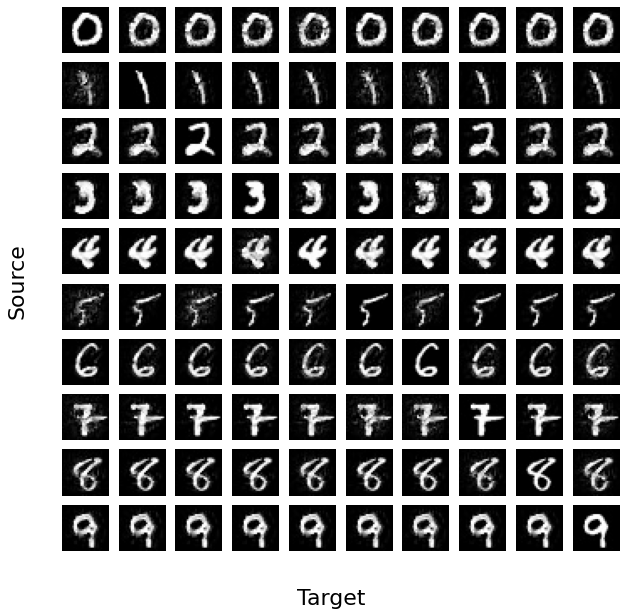

In [ ]:
from sys import implementation
images = os.listdir('/content/drive/MyDrive/Thesis/100_advs')
images = sorted(images)
num_subplots = 10
fig, axes = plt.subplots(nrows=num_subplots, ncols=num_subplots, figsize=(10,10))
for idx,ax in tqdm(enumerate(axes.ravel())): 
    imgl = cv2.imread('/content/drive/MyDrive/Thesis/100_advs/'+images[idx])
    ax.imshow(np.array(imgl), cmap = 'gray')
    ax.axis("off")
fig.text(0.5, 0.09, 'Target', ha='center')
fig.text(0.09, 0.5, 'Source', va='center', rotation='vertical')
plt.show()



In [ ]:
table = [[0]*10 for _ in range(10)]

for i in tqdm(range(10)):
    im1 = cv2.imread('/content/drive/MyDrive/Thesis/100_advs_cifar/'+str(i)+"_"+str(i)+".jpg")
    for j in range(10):
        im2 = cv2.imread('/content/drive/MyDrive/Thesis/100_advs_cifar/'+str(i)+"_"+str(j)+".jpg")
        table[i][j] = np.round(np.linalg.norm(im1-im2),decimals=1)

tab1 = pd.DataFrame(np.asarray(table))
print(tab1.to_latex(index=True))

100%|██████████| 10/10 [00:12<00:00,  1.24s/it]

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &       0 &       1 &       2 &       3 &       4 &       5 &       6 &       7 &       8 &       9 \\
\midrule
0 &     0.0 &     0.0 &     0.0 &  9348.5 &     0.0 &  9388.4 &  9218.4 &     0.0 &     0.0 &     0.0 \\
1 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &  9294.3 &  9312.7 &     0.0 &     0.0 &     0.0 \\
2 &     0.0 &     0.0 &     0.0 &  9384.6 &  9405.6 &  9043.8 &  9105.4 &     0.0 &     0.0 &     0.0 \\
3 &  9066.7 &  9066.7 &  9066.7 &     0.0 &  9066.7 &  9066.7 &  9413.7 &  9066.7 &  9066.7 &  9066.7 \\
4 &  9545.1 &  9545.1 &  9545.1 &  9304.0 &     0.0 &  9397.0 &  9241.1 &  9545.1 &  9545.1 &  9545.1 \\
5 &  9454.1 &  9454.1 &  9441.0 &  9231.0 &  9454.1 &     0.0 &  9223.4 &  9454.1 &  9454.1 &  9454.1 \\
6 &  9442.7 &  9542.8 &  9442.7 &  9378.5 &  9442.7 &  9426.3 &     0.0 &  9481.3 &  9442.7 &  9442.7 \\
7 &  9469.8 &  9469.8 &  8959.9 &  9296.4 &  9674.8 &  8880.6 &  8983.7 &     0.0 &  9469.8 &  9296.4 \\
8 &    

**10,000**

In [ ]:
adv,nat = adv_error(X_test[:1000],mnist_model,num_classes=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 1 ====


  0%|          | 1/1000 [00:15<4:13:20, 15.22s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====


  0%|          | 2/1000 [04:42<45:17:02, 163.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  0%|          | 3/1000 [05:22<29:39:30, 107.09s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  0%|          | 4/1000 [07:05<29:12:53, 105.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 5/1000 [09:31<33:09:04, 119.94s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


  1%|          | 6/1000 [11:06<30:46:16, 111.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  1%|          | 7/1000 [13:06<31:33:28, 114.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====


  1%|          | 8/1000 [15:27<33:51:24, 122.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  1%|          | 9/1000 [19:22<43:26:04, 157.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  1%|          | 10/1000 [21:01<38:27:51, 139.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


  1%|          | 11/1000 [24:31<44:19:58, 161.37s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  1%|          | 12/1000 [25:08<33:52:29, 123.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  1%|▏         | 13/1000 [26:39<31:08:54, 113.61s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
===

  1%|▏         | 14/1000 [32:57<53:00:52, 193.56s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 15/1000 [35:46<50:55:59, 186.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 16/1000 [37:16<42:53:56, 156.95s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


  2%|▏         | 17/1000 [37:58<33:27:49, 122.55s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  2%|▏         | 18/1000 [38:53<27:50:52, 102.09s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


  2%|▏         | 19/1000 [42:52<39:01:55, 143.24s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 20/1000 [44:25<34:53:43, 128.19s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  2%|▏         | 21/1000 [45:52<31:31:24, 115.92s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  2%|▏         | 22/1000 [49:00<37:19:51, 137.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  2%|▏         | 23/1000 [51:28<38:12:51, 140.81s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 24/1000 [53:05<34:34:24, 127.53s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  2%|▎         | 25/1000 [55:26<35:36:13, 131.46s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  3%|▎         | 26/1000 [56:21<29:24:55, 108.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  3%|▎         | 27/1000 [59:41<36:46:32, 136.07s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  3%|▎         | 28/1000 [1:02:53<41:13:36, 152.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  3%|▎         | 29/1000 [1:05:36<42:01:04, 155.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  3%|▎         | 30/1000 [1:08:49<44:59:12, 166.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


  3%|▎         | 31/1000 [1:11:09<42:48:05, 159.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  3%|▎         | 32/1000 [1:12:17<35:26:52, 131.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  3%|▎         | 33/1000 [1:15:10<38:40:45, 144.00s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====


  3%|▎         | 34/1000 [1:17:34<38:40:41, 144.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  4%|▎         | 35/1000 [1:18:27<31:17:38, 116.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  4%|▎         | 36/1000 [1:21:40<37:21:32, 139.51s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  4%|▎         | 37/1000 [1:24:35<40:10:09, 150.17s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


  4%|▍         | 38/1000 [1:27:29<42:03:38, 157.40s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  4%|▍         | 39/1000 [1:32:26<53:09:00, 199.11s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====


  4%|▍         | 40/1000 [1:35:20<51:07:00, 191.69s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  4%|▍         | 41/1000 [1:36:16<40:12:49, 150.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====


  4%|▍         | 42/1000 [1:38:33<39:03:56, 146.80s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  4%|▍         | 43/1000 [1:39:24<31:21:44, 117.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  4%|▍         | 44/1000 [1:43:51<43:14:23, 162.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  4%|▍         | 45/1000 [1:44:51<34:59:35, 131.91s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  5%|▍         | 46/1000 [1:47:55<39:07:01, 147.61s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
===

  5%|▍         | 47/1000 [1:54:05<56:41:33, 214.16s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  5%|▍         | 48/1000 [1:54:42<42:37:04, 161.16s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▍         | 49/1000 [1:56:27<38:08:48, 144.40s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▌         | 50/1000 [2:01:57<52:45:14, 199.91s/it]

====ROUND 1 ====
====ROUND 1 ====


  5%|▌         | 51/1000 [2:02:19<38:36:35, 146.47s/it]

====ROUND 1 ====
====ROUND 2 ====


  5%|▌         | 52/1000 [2:02:41<28:45:12, 109.19s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  5%|▌         | 53/1000 [2:04:17<27:44:03, 105.43s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  5%|▌         | 54/1000 [2:04:56<22:24:12, 85.26s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====


  6%|▌         | 55/1000 [2:10:19<41:09:30, 156.79s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


  6%|▌         | 56/1000 [2:13:29<43:43:29, 166.75s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▌         | 57/1000 [2:17:39<50:12:57, 191.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


  6%|▌         | 58/1000 [2:19:07<41:57:48, 160.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  6%|▌         | 59/1000 [2:23:17<48:58:09, 187.34s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  6%|▌         | 60/1000 [2:26:53<51:13:04, 196.15s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▌         | 61/1000 [2:27:28<38:30:54, 147.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  6%|▌         | 62/1000 [2:30:17<40:09:21, 154.12s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


  6%|▋         | 63/1000 [2:31:04<31:44:15, 121.94s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


  6%|▋         | 64/1000 [2:35:06<41:01:39, 157.80s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  6%|▋         | 65/1000 [2:39:19<48:28:30, 186.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


  7%|▋         | 66/1000 [2:40:46<40:39:37, 156.72s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  7%|▋         | 67/1000 [2:41:54<33:42:14, 130.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  7%|▋         | 68/1000 [2:46:11<43:31:47, 168.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  7%|▋         | 69/1000 [2:50:04<48:30:52, 187.60s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


  7%|▋         | 70/1000 [2:51:57<42:41:45, 165.28s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  7%|▋         | 71/1000 [2:52:38<33:01:14, 127.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  7%|▋         | 72/1000 [2:54:25<31:20:00, 121.55s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  7%|▋         | 73/1000 [2:56:14<30:18:09, 117.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  7%|▋         | 74/1000 [2:57:58<29:13:01, 113.59s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


  8%|▊         | 75/1000 [3:00:37<32:41:39, 127.24s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ==

  8%|▊         | 76/1000 [3:07:32<54:48:30, 213.54s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  8%|▊         | 77/1000 [3:08:00<40:32:13, 158.11s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  8%|▊         | 78/1000 [3:11:02<42:17:40, 165.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  8%|▊         | 79/1000 [3:12:09<34:44:56, 135.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  8%|▊         | 80/1000 [3:13:02<28:19:53, 110.86s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


  8%|▊         | 81/1000 [3:14:58<28:43:22, 112.52s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  8%|▊         | 82/1000 [3:15:38<23:06:23, 90.61s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  8%|▊         | 83/1000 [3:18:23<28:47:02, 113.00s/it]

====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  8%|▊         | 84/1000 [3:19:32<25:22:21, 99.72s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  8%|▊         | 85/1000 [3:21:32<26:52:35, 105.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  9%|▊         | 86/1000 [3:22:30<23:15:04, 91.58s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  9%|▊         | 87/1000 [3:23:16<19:44:09, 77.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 88/1000 [3:26:12<27:13:26, 107.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 89/1000 [3:27:27<24:42:40, 97.65s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


  9%|▉         | 90/1000 [3:28:11<20:34:56, 81.42s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 91/1000 [3:31:44<30:34:49, 121.11s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  9%|▉         | 92/1000 [3:32:46<26:00:47, 103.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 93/1000 [3:33:27<21:19:00, 84.61s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 94/1000 [3:34:34<19:57:43, 79.32s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====


 10%|▉         | 95/1000 [3:36:01<20:30:46, 81.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 10%|▉         | 96/1000 [3:37:34<21:19:45, 84.94s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 10%|▉         | 97/1000 [3:40:24<27:46:01, 110.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ===

 10%|▉         | 98/1000 [3:45:24<41:56:04, 167.37s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 10%|▉         | 99/1000 [3:47:15<37:39:57, 150.50s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 10%|█         | 100/1000 [3:47:42<28:20:52, 113.39s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 10%|█         | 101/1000 [3:48:24<22:57:57, 91.97s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====


 10%|█         | 102/1000 [3:51:02<27:53:39, 111.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 10%|█         | 103/1000 [3:54:22<34:27:23, 138.29s/it]

====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 10%|█         | 104/1000 [3:57:24<37:38:29, 151.24s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====


 10%|█         | 105/1000 [3:59:27<35:30:14, 142.81s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 11%|█         | 106/1000 [3:59:57<27:02:39, 108.90s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 11%|█         | 107/1000 [4:01:39<26:30:44, 106.88s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 11%|█         | 108/1000 [4:02:32<22:28:27, 90.70s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 11%|█         | 109/1000 [4:04:41<25:17:49, 102.21s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====


 11%|█         | 110/1000 [4:05:57<23:21:31, 94.48s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====


 11%|█         | 111/1000 [4:09:01<29:56:05, 121.22s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 11%|█         | 112/1000 [4:12:48<37:42:54, 152.90s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 11%|█▏        | 113/1000 [4:14:59<36:02:46, 146.30s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 11%|█▏        | 114/1000 [4:17:11<34:59:49, 142.20s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 12%|█▏        | 115/1000 [4:20:06<37:19:56, 151.86s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


 12%|█▏        | 116/1000 [4:23:34<41:29:37, 168.98s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 12%|█▏        | 117/1000 [4:23:55<30:30:01, 124.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUN

 12%|█▏        | 118/1000 [4:29:08<44:19:09, 180.90s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 12%|█▏        | 119/1000 [4:32:43<46:48:29, 191.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====


 12%|█▏        | 120/1000 [4:36:34<49:38:12, 203.06s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====


 12%|█▏        | 121/1000 [4:39:18<46:44:51, 191.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 12%|█▏        | 122/1000 [4:42:21<46:05:13, 188.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 12%|█▏        | 123/1000 [4:45:00<43:51:47, 180.05s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 12%|█▏        | 124/1000 [4:46:55<39:00:45, 160.33s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 12%|█▎        | 125/1000 [4:49:23<38:04:51, 156.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ==

 13%|█▎        | 126/1000 [4:56:22<57:09:45, 235.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 13%|█▎        | 127/1000 [5:01:31<62:25:02, 257.39s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 13%|█▎        | 128/1000 [5:05:34<61:19:32, 253.18s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


 13%|█▎        | 129/1000 [5:07:46<52:26:45, 216.77s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 13%|█▎        | 130/1000 [5:12:02<55:16:05, 228.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 13%|█▎        | 131/1000 [5:12:35<40:59:11, 169.79s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 13%|█▎        | 132/1000 [5:14:22<36:22:49, 150.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 13%|█▎        | 133/1000 [5:16:40<35:28:03, 147.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 13%|█▎        | 134/1000 [5:19:25<36:40:15, 152.44s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


 14%|█▎        | 135/1000 [5:23:46<44:29:56, 185.20s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====


 14%|█▎        | 136/1000 [5:26:42<43:46:04, 182.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 14%|█▎        | 137/1000 [5:27:44<35:02:49, 146.20s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 14%|█▍        | 138/1000 [5:28:39<28:25:09, 118.69s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 14%|█▍        | 139/1000 [5:30:09<26:20:54, 110.17s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 14%|█▍        | 140/1000 [5:32:22<27:56:22, 116.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 14%|█▍        | 141/1000 [5:33:43<25:20:42, 106.22s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====


 14%|█▍        | 142/1000 [5:36:48<30:58:31, 129.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 14%|█▍        | 143/1000 [5:42:14<44:55:40, 188.73s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 14%|█▍        | 144/1000 [5:43:00<34:41:17, 145.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 14%|█▍        | 145/1000 [5:45:57<36:53:17, 155.32s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 15%|█▍        | 146/1000 [5:49:41<41:41:00, 175.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 15%|█▍        | 147/1000 [5:52:58<43:11:53, 182.31s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 15%|█▍        | 148/1000 [5:55:12<39:40:15, 167.62s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▍        | 149/1000 [5:56:39<33:54:54, 143.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


In [ ]:
adv,nat = adv_error(X_test[148:1000],Y_test[148:1000],mnist_model,num_classes=10)

  0%|          | 0/852 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 1/852 [01:34<22:22:22, 94.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


  0%|          | 2/852 [06:00<46:11:32, 195.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 3/852 [06:52<30:37:07, 129.83s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


  0%|          | 4/852 [11:55<46:42:42, 198.30s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  1%|          | 5/852 [15:27<47:48:45, 203.22s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  1%|          | 6/852 [17:16<40:11:07, 171.00s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  1%|          | 7/852 [18:15<31:32:15, 134.36s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  1%|          | 8/852 [22:50<41:59:39, 179.12s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  1%|          | 9/852 [26:32<45:04:56, 192.52s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  1%|          | 10/852 [30:43<49:16:12, 210.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  1%|▏         | 11/852 [32:49<43:08:45, 184.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  1%|▏         | 12/852 [36:14<44:32:05, 190.86s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 13/852 [37:09<34:56:23, 149.92s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 14/852 [38:32<30:12:18, 129.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  2%|▏         | 15/852 [41:38<34:06:15, 146.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 16/852 [46:32<44:21:04, 190.99s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  2%|▏         | 17/852 [46:58<32:44:59, 141.20s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  2%|▏         | 18/852 [50:04<35:52:46, 154.88s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  2%|▏         | 19/852 [51:56<32:51:09, 141.98s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 20/852 [53:17<28:32:00, 123.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====


  2%|▏         | 21/852 [55:12<27:54:21, 120.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  3%|▎         | 22/852 [55:59<22:45:53, 98.74s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  3%|▎         | 23/852 [57:24<21:49:59, 94.81s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  3%|▎         | 24/852 [58:27<19:37:01, 85.29s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  3%|▎         | 25/852 [1:01:13<25:09:09, 109.49s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====


  3%|▎         | 26/852 [1:02:03<21:01:02, 91.60s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  3%|▎         | 27/852 [1:05:18<28:04:32, 122.51s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====


  3%|▎         | 28/852 [1:07:51<30:08:31, 131.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  3%|▎         | 29/852 [1:08:26<23:28:05, 102.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  4%|▎         | 30/852 [1:10:04<23:08:02, 101.32s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


  4%|▎         | 31/852 [1:11:56<23:52:08, 104.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  4%|▍         | 32/852 [1:15:40<31:58:27, 140.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


  4%|▍         | 33/852 [1:17:15<28:50:16, 126.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  4%|▍         | 34/852 [1:20:10<32:06:27, 141.30s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  4%|▍         | 35/852 [1:23:29<35:59:14, 158.57s/it]

====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  4%|▍         | 36/852 [1:27:35<41:54:02, 184.86s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  4%|▍         | 37/852 [1:31:11<43:56:01, 194.06s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  4%|▍         | 38/852 [1:35:32<48:23:14, 214.00s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


  5%|▍         | 39/852 [1:37:43<42:45:23, 189.33s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  5%|▍         | 40/852 [1:38:39<33:38:47, 149.17s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 =

  5%|▍         | 41/852 [1:47:16<58:30:03, 259.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▍         | 42/852 [1:51:04<56:17:52, 250.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▌         | 43/852 [1:52:35<45:26:05, 202.18s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  5%|▌         | 44/852 [1:56:25<47:17:53, 210.73s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


  5%|▌         | 45/852 [1:58:07<39:55:02, 178.07s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  5%|▌         | 46/852 [2:01:18<40:45:33, 182.05s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  6%|▌         | 47/852 [2:02:09<31:51:29, 142.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  6%|▌         | 48/852 [2:03:06<26:08:09, 117.03s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


  6%|▌         | 49/852 [2:04:39<24:28:44, 109.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  6%|▌         | 50/852 [2:06:56<26:16:49, 117.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▌         | 51/852 [2:08:06<23:02:01, 103.52s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  6%|▌         | 52/852 [2:11:03<27:56:00, 125.70s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▌         | 53/852 [2:12:10<23:59:21, 108.09s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  6%|▋         | 54/852 [2:14:16<25:07:57, 113.38s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====


  6%|▋         | 55/852 [2:16:03<24:41:52, 111.56s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  7%|▋         | 56/852 [2:17:08<21:33:00, 97.46s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  7%|▋         | 57/852 [2:18:24<20:04:57, 90.94s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  7%|▋         | 58/852 [2:19:46<19:27:25, 88.22s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  7%|▋         | 59/852 [2:22:07<22:56:11, 104.13s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  7%|▋         | 60/852 [2:23:50<22:50:35, 103.83s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  7%|▋         | 61/852 [2:24:59<20:29:24, 93.25s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  7%|▋         | 62/852 [2:29:15<31:12:40, 142.23s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====


  7%|▋         | 63/852 [2:32:36<35:01:05, 159.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

  8%|▊         | 64/852 [2:42:22<62:58:11, 287.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====


  8%|▊         | 65/852 [2:47:51<65:34:56, 300.00s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


  8%|▊         | 66/852 [2:51:04<58:31:56, 268.09s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  8%|▊         | 67/852 [2:52:23<46:03:03, 211.19s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====

  8%|▊         | 68/852 [2:59:35<60:27:30, 277.62s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


  8%|▊         | 69/852 [3:03:51<58:58:46, 271.17s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  8%|▊         | 70/852 [3:09:24<62:55:08, 289.65s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====


  8%|▊         | 71/852 [3:12:42<56:52:17, 262.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


  8%|▊         | 72/852 [3:16:02<52:44:42, 243.44s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▊         | 73/852 [3:19:01<48:29:36, 224.10s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


  9%|▊         | 74/852 [3:19:44<36:43:15, 169.92s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  9%|▉         | 75/852 [3:21:02<30:40:41, 142.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  9%|▉         | 76/852 [3:23:05<29:24:52, 136.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  9%|▉         | 77/852 [3:24:07<24:33:57, 114.11s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  9%|▉         | 78/852 [3:27:32<30:25:22, 141.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 79/852 [3:28:03<23:14:52, 108.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  9%|▉         | 80/852 [3:30:13<24:35:00, 114.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====


 10%|▉         | 81/852 [3:31:38<22:39:05, 105.77s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


 10%|▉         | 82/852 [3:33:18<22:15:09, 104.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ===

 10%|▉         | 83/852 [3:40:21<42:39:32, 199.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


 10%|▉         | 84/852 [3:41:45<35:13:17, 165.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 10%|▉         | 85/852 [3:44:36<35:35:17, 167.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====


 10%|█         | 86/852 [3:46:22<31:35:48, 148.50s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 10%|█         | 87/852 [3:47:03<24:45:12, 116.49s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 10%|█         | 88/852 [3:48:11<21:36:33, 101.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 10%|█         | 89/852 [3:52:10<30:16:20, 142.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 11%|█         | 90/852 [3:53:19<25:32:59, 120.71s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 11%|█         | 91/852 [3:56:04<28:20:02, 134.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


 11%|█         | 92/852 [3:57:59<27:06:56, 128.44s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


 11%|█         | 93/852 [4:00:03<26:48:06, 127.12s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====


 11%|█         | 94/852 [4:01:26<23:59:13, 113.92s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 11%|█         | 95/852 [4:02:15<19:50:48, 94.38s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 11%|█▏        | 96/852 [4:06:01<28:04:30, 133.69s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 12%|█▏        | 98/852 [4:09:23<22:47:29, 108.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

 12%|█▏        | 99/852 [4:21:20<60:53:41, 291.13s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====


 12%|█▏        | 100/852 [4:24:12<53:20:44, 255.38s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 12%|█▏        | 101/852 [4:24:52<39:50:31, 190.99s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


 12%|█▏        | 102/852 [4:26:09<32:37:26, 156.59s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


 12%|█▏        | 103/852 [4:28:15<30:42:57, 147.63s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 12%|█▏        | 104/852 [4:30:12<28:45:42, 138.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====


 12%|█▏        | 105/852 [4:32:32<28:48:13, 138.81s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 12%|█▏        | 106/852 [4:37:30<38:38:32, 186.48s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 13%|█▎        | 107/852 [4:38:57<32:27:44, 156.86s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 13%|█▎        | 108/852 [4:41:57<33:48:40, 163.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 13%|█▎        | 109/852 [4:44:27<32:57:39, 159.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 13%|█▎        | 110/852 [4:47:43<35:09:06, 170.55s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 13%|█▎        | 111/852 [4:50:04<33:15:32, 161.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 13%|█▎        | 112/852 [4:52:18<31:30:11, 153.26s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 13%|█▎        | 113/852 [4:55:39<34:23:40, 167.55s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 13%|█▎        | 114/852 [5:00:44<42:49:04, 208.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 13%|█▎        | 115/852 [5:02:26<36:11:51, 176.81s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 =

 14%|█▎        | 116/852 [5:09:38<51:47:26, 253.32s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 14%|█▎        | 117/852 [5:11:33<43:17:17, 212.02s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


 14%|█▍        | 118/852 [5:12:35<34:01:04, 166.85s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 14%|█▍        | 119/852 [5:13:17<26:20:26, 129.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 14%|█▍        | 120/852 [5:15:59<28:20:11, 139.36s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 14%|█▍        | 121/852 [5:16:52<22:59:19, 113.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 14%|█▍        | 122/852 [5:21:18<32:15:39, 159.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 14%|█▍        | 123/852 [5:25:03<36:14:38, 178.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▍        | 124/852 [5:26:37<31:02:17, 153.49s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROU

 15%|█▍        | 125/852 [5:33:26<46:27:54, 230.09s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 15%|█▍        | 126/852 [5:35:18<39:15:45, 194.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====R

 15%|█▍        | 127/852 [5:41:54<51:20:26, 254.93s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▌        | 128/852 [5:43:19<41:00:43, 203.93s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====


 15%|█▌        | 129/852 [5:45:19<35:55:45, 178.90s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▌        | 130/852 [5:48:39<37:09:25, 185.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 15%|█▌        | 131/852 [5:51:59<37:59:26, 189.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▌        | 132/852 [5:54:23<35:09:54, 175.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 16%|█▌        | 133/852 [5:59:19<42:18:43, 211.85s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


 16%|█▌        | 134/852 [6:02:26<40:48:35, 204.62s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 16%|█▌        | 135/852 [6:06:02<41:23:43, 207.84s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 16%|█▌        | 136/852 [6:09:06<39:55:47, 200.77s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 16%|█▌        | 137/852 [6:11:04<34:57:29, 176.01s/it]

====ROUND 1 ====
====ROUND 1 ====


 16%|█▌        | 138/852 [6:11:24<25:38:35, 129.29s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 16%|█▋        | 139/852 [6:12:04<20:17:41, 102.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 

 16%|█▋        | 140/852 [6:24:01<56:43:11, 286.79s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


 17%|█▋        | 141/852 [6:25:44<45:42:41, 231.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 17%|█▋        | 142/852 [6:27:14<37:16:39, 189.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====


In [ ]:
adv,nat = adv_error(X_test[290:1000],Y_test[290:1000],mnist_model,num_classes=10)

  0%|          | 0/710 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
==

  0%|          | 1/710 [07:47<92:00:59, 467.22s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  0%|          | 2/710 [11:28<63:26:16, 322.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  0%|          | 3/710 [13:41<46:18:07, 235.77s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====


  1%|          | 4/710 [16:25<40:45:21, 207.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  1%|          | 5/710 [18:31<34:51:20, 177.99s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  1%|          | 6/710 [24:34<47:07:19, 240.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  1%|          | 7/710 [30:49<55:37:17, 284.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  1%|          | 8/710 [36:35<59:19:49, 304.26s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


  1%|▏         | 9/710 [37:18<43:19:53, 222.53s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  1%|▏         | 10/710 [44:01<54:07:31, 278.36s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 11/710 [50:03<59:00:15, 303.88s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  2%|▏         | 12/710 [53:48<54:15:46, 279.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


  2%|▏         | 13/710 [55:28<43:37:58, 225.36s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  2%|▏         | 14/710 [57:00<35:46:45, 185.07s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  2%|▏         | 15/710 [57:33<26:53:10, 139.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  2%|▏         | 16/710 [1:00:33<29:15:18, 151.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  2%|▏         | 17/710 [1:05:31<37:40:44, 195.74s/it]

====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  3%|▎         | 18/710 [1:10:26<43:21:27, 225.56s/it]

====ROUND 1 ====


  3%|▎         | 20/710 [1:10:59<22:41:55, 118.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====


  3%|▎         | 21/710 [1:14:40<28:32:02, 149.09s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  3%|▎         | 22/710 [1:15:40<23:25:48, 122.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  3%|▎         | 23/710 [1:20:17<32:11:51, 168.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  3%|▎         | 24/710 [1:24:18<36:18:58, 190.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====


  4%|▎         | 25/710 [1:27:36<36:40:23, 192.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  4%|▎         | 26/710 [1:32:56<43:53:30, 231.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  4%|▍         | 27/710 [1:38:09<48:27:00, 255.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  4%|▍         | 28/710 [1:43:31<52:10:47, 275.44s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  4%|▍         | 29/710 [1:47:10<48:54:46, 258.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====


  4%|▍         | 30/710 [1:52:19<51:41:54, 273.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


  4%|▍         | 31/710 [1:56:52<51:35:21, 273.52s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▍         | 32/710 [1:59:50<46:07:18, 244.90s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====


  5%|▍         | 33/710 [2:00:55<35:54:56, 190.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ===

  5%|▍         | 34/710 [2:10:34<57:40:20, 307.13s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====


  5%|▍         | 35/710 [2:14:08<52:21:38, 279.26s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  5%|▌         | 36/710 [2:14:56<39:17:33, 209.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▌         | 37/710 [2:17:21<35:35:55, 190.42s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  5%|▌         | 38/710 [2:20:54<36:48:51, 197.22s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  5%|▌         | 39/710 [2:26:17<43:46:49, 234.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


  6%|▌         | 40/710 [2:28:54<39:23:24, 211.65s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▌         | 41/710 [2:31:59<37:49:48, 203.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  6%|▌         | 42/710 [2:36:17<40:47:32, 219.84s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  6%|▌         | 43/710 [2:38:17<35:11:24, 189.93s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 =

  6%|▌         | 44/710 [2:47:56<56:43:51, 306.65s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▋         | 45/710 [2:49:40<45:26:24, 245.99s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▋         | 46/710 [2:52:46<42:01:39, 227.86s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====


  7%|▋         | 47/710 [2:55:33<38:35:28, 209.54s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====R

  7%|▋         | 48/710 [3:02:50<51:05:30, 277.84s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  7%|▋         | 49/710 [3:05:20<44:00:35, 239.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  7%|▋         | 50/710 [3:08:42<41:50:15, 228.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  7%|▋         | 51/710 [3:14:45<49:10:40, 268.65s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  7%|▋         | 52/710 [3:16:31<40:12:01, 219.94s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====


  7%|▋         | 53/710 [3:19:17<37:09:13, 203.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  8%|▊         | 54/710 [3:22:35<36:50:24, 202.17s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  8%|▊         | 55/710 [3:24:31<32:04:06, 176.25s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====


  8%|▊         | 56/710 [3:28:30<35:27:11, 195.15s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  8%|▊         | 57/710 [3:29:28<27:56:06, 154.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  8%|▊         | 58/710 [3:34:14<35:04:00, 193.62s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


  8%|▊         | 59/710 [3:35:12<27:39:03, 152.91s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====


  8%|▊         | 60/710 [3:40:18<35:53:28, 198.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  9%|▊         | 61/710 [3:46:12<44:11:39, 245.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  9%|▊         | 62/710 [3:49:56<43:00:45, 238.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 63/710 [3:51:09<33:58:46, 189.07s/it]

====ROUND 1 ====
====ROUND 1 ====


  9%|▉         | 64/710 [3:51:25<24:36:40, 137.15s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 65/710 [3:52:00<19:05:46, 106.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  9%|▉         | 66/710 [3:52:51<16:05:08, 89.92s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 

  9%|▉         | 67/710 [4:04:20<48:09:41, 269.65s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 10%|▉         | 68/710 [4:04:55<35:30:56, 199.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 10%|▉         | 69/710 [4:09:06<38:15:35, 214.88s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====


 10%|▉         | 70/710 [4:11:27<34:16:18, 192.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

 10%|█         | 71/710 [4:26:08<70:49:17, 398.99s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 10%|█         | 72/710 [4:30:00<61:52:37, 349.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
=

 10%|█         | 73/710 [4:39:23<73:07:05, 413.23s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND

 10%|█         | 74/710 [4:47:14<76:04:18, 430.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 11%|█         | 75/710 [4:50:35<63:45:55, 361.50s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 11%|█         | 76/710 [4:54:52<58:09:56, 330.28s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 11%|█         | 77/710 [4:57:34<49:12:57, 279.90s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
=

 11%|█         | 78/710 [5:04:48<57:13:02, 325.92s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 11%|█         | 79/710 [5:05:37<42:35:03, 242.95s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 11%|█▏        | 80/710 [5:06:19<31:59:06, 182.77s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 11%|█▏        | 81/710 [5:08:56<30:32:38, 174.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 12%|█▏        | 82/710 [5:14:49<39:50:29, 228.39s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====


In [ ]:
adv,nat = adv_error(X_test[394:1000],Y_test[394:1000],mnist_model,num_classes=10)

  0%|          | 0/606 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 1/606 [03:10<32:01:31, 190.56s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROU

  0%|          | 2/606 [09:57<53:21:53, 318.07s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  0%|          | 3/606 [13:15<44:05:32, 263.24s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUN

  1%|          | 4/606 [20:09<53:58:36, 322.79s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  1%|          | 5/606 [25:43<54:32:42, 326.73s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  1%|          | 6/606 [28:36<45:44:01, 274.40s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  1%|          | 7/606 [36:08<55:19:26, 332.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====


  1%|▏         | 8/606 [39:11<47:19:56, 284.94s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  1%|▏         | 9/606 [41:19<39:07:07, 235.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  2%|▏         | 10/606 [42:50<31:39:13, 191.20s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  2%|▏         | 11/606 [43:28<23:49:18, 144.13s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====

  2%|▏         | 12/606 [52:48<44:38:53, 270.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 13/606 [54:57<37:30:11, 227.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


  2%|▏         | 14/606 [58:27<36:35:03, 222.47s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  2%|▏         | 15/606 [58:59<27:07:17, 165.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  3%|▎         | 16/606 [59:29<20:24:19, 124.51s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  3%|▎         | 17/606 [1:02:43<23:45:54, 145.25s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  3%|▎         | 18/606 [1:08:40<34:07:06, 208.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  3%|▎         | 19/606 [1:11:53<33:18:16, 204.25s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  3%|▎         | 20/606 [1:13:00<26:30:43, 162.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====


  3%|▎         | 21/606 [1:16:47<29:35:26, 182.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====


  4%|▎         | 22/606 [1:19:37<28:56:10, 178.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  4%|▍         | 23/606 [1:20:32<22:56:04, 141.62s/it]

====ROUND 1 ====


  4%|▍         | 24/606 [1:20:47<16:44:16, 103.53s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  4%|▍         | 25/606 [1:21:51<14:46:41, 91.57s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


  4%|▍         | 26/606 [1:23:29<15:04:40, 93.59s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  4%|▍         | 27/606 [1:25:49<17:18:38, 107.63s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  5%|▍         | 28/606 [1:30:57<26:55:50, 167.73s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  5%|▍         | 29/606 [1:32:31<23:18:35, 145.43s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  5%|▍         | 30/606 [1:35:54<26:03:33, 162.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  5%|▌         | 31/606 [1:37:25<22:33:08, 141.20s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  5%|▌         | 32/606 [1:40:06<23:27:41, 147.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  5%|▌         | 33/606 [1:42:19<22:44:01, 142.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  6%|▌         | 34/606 [1:43:19<18:46:35, 118.17s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  6%|▌         | 35/606 [1:46:36<22:27:30, 141.59s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▌         | 36/606 [1:47:32<18:23:24, 116.15s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  6%|▌         | 37/606 [1:48:15<14:53:19, 94.20s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


  6%|▋         | 38/606 [1:50:37<17:05:08, 108.29s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▋         | 39/606 [1:53:22<19:45:58, 125.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ==

  7%|▋         | 40/606 [2:01:20<36:21:39, 231.27s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  7%|▋         | 41/606 [2:02:48<29:31:18, 188.10s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  7%|▋         | 42/606 [2:04:32<25:32:07, 162.99s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====


  7%|▋         | 43/606 [2:06:37<23:42:04, 151.55s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====


  7%|▋         | 44/606 [2:11:12<29:27:19, 188.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  7%|▋         | 45/606 [2:15:43<33:14:28, 213.31s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  8%|▊         | 46/606 [2:18:20<30:33:11, 196.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  8%|▊         | 47/606 [2:20:17<26:49:11, 172.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====


  8%|▊         | 48/606 [2:24:26<30:17:46, 195.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====


  8%|▊         | 49/606 [2:28:19<31:57:53, 206.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  8%|▊         | 50/606 [2:30:58<29:44:30, 192.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  8%|▊         | 51/606 [2:31:39<22:40:08, 147.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  9%|▊         | 52/606 [2:33:54<22:04:38, 143.46s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  9%|▊         | 53/606 [2:34:31<17:06:46, 111.40s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  9%|▉         | 54/606 [2:40:27<28:19:43, 184.75s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 55/606 [2:41:31<22:43:48, 148.51s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  9%|▉         | 56/606 [2:44:26<23:54:49, 156.53s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  9%|▉         | 57/606 [2:48:48<28:40:35, 188.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 10%|▉         | 58/606 [2:50:13<23:56:27, 157.28s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 10%|▉         | 59/606 [2:56:35<34:08:24, 224.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUN

 10%|▉         | 60/606 [3:03:31<42:45:27, 281.92s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 10%|█         | 61/606 [3:04:49<33:25:47, 220.82s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 10%|█         | 62/606 [3:05:55<26:21:17, 174.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 10%|█         | 63/606 [3:10:27<30:43:01, 203.65s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====


 11%|█         | 64/606 [3:13:49<30:35:49, 203.23s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 11%|█         | 65/606 [3:18:30<34:02:52, 226.57s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 11%|█         | 66/606 [3:20:06<28:05:10, 187.24s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 11%|█         | 67/606 [3:22:55<27:14:36, 181.96s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 11%|█         | 68/606 [3:24:48<24:06:14, 161.29s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 11%|█▏        | 69/606 [3:28:00<25:24:38, 170.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 12%|█▏        | 70/606 [3:28:56<20:16:10, 136.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 12%|█▏        | 71/606 [3:31:20<20:35:30, 138.56s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 12%|█▏        | 72/606 [3:35:00<24:10:30, 162.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 12%|█▏        | 73/606 [3:39:05<27:44:54, 187.42s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ==

 12%|█▏        | 74/606 [3:47:30<41:48:35, 282.92s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 12%|█▏        | 75/606 [3:48:27<31:41:59, 214.91s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====


 13%|█▎        | 76/606 [3:55:01<39:33:12, 268.67s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
===

 13%|█▎        | 77/606 [4:02:40<47:53:08, 325.88s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 13%|█▎        | 78/606 [4:04:42<38:49:28, 264.71s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 13%|█▎        | 79/606 [4:06:20<31:26:40, 214.80s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 13%|█▎        | 80/606 [4:07:32<25:06:38, 171.86s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 13%|█▎        | 81/606 [4:09:22<22:21:20, 153.30s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

 14%|█▎        | 82/606 [4:24:24<54:59:26, 377.80s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====


 14%|█▎        | 83/606 [4:28:42<49:40:12, 341.90s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 14%|█▍        | 84/606 [4:32:58<45:50:12, 316.12s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====


 14%|█▍        | 85/606 [4:35:39<39:01:21, 269.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


 14%|█▍        | 86/606 [4:38:10<33:48:09, 234.02s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 14%|█▍        | 87/606 [4:38:43<25:03:02, 173.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 15%|█▍        | 88/606 [4:41:05<23:37:57, 164.24s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▍        | 89/606 [4:44:05<24:16:36, 169.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▍        | 90/606 [4:46:28<23:04:26, 160.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 15%|█▌        | 91/606 [4:48:30<21:22:55, 149.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 15%|█▌        | 92/606 [4:51:26<22:27:52, 157.34s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====


 15%|█▌        | 93/606 [4:53:46<21:40:00, 152.05s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====


 16%|█▌        | 94/606 [4:55:31<19:37:16, 137.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====


 16%|█▌        | 95/606 [4:57:59<20:02:42, 141.22s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 16%|█▌        | 96/606 [4:59:49<18:39:47, 131.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 16%|█▌        | 97/606 [5:05:22<27:10:17, 192.18s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 16%|█▌        | 98/606 [5:06:17<21:17:23, 150.87s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 16%|█▋        | 99/606 [5:09:04<21:55:26, 155.67s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 17%|█▋        | 100/606 [5:11:38<21:50:03, 155.34s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 17%|█▋        | 101/606 [5:12:35<17:39:14, 125.85s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 17%|█▋        | 102/606 [5:12:57<13:14:24, 94.57s/it] 

====ROUND 1 ====


 17%|█▋        | 103/606 [5:13:17<10:04:59, 72.17s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 17%|█▋        | 104/606 [5:14:54<11:07:52, 79.83s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 17%|█▋        | 105/606 [5:16:03<10:39:05, 76.54s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 17%|█▋        | 106/606 [5:17:03<9:56:12, 71.54s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 18%|█▊        | 107/606 [5:20:47<16:15:39, 117.31s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12

 18%|█▊        | 108/606 [5:28:44<31:08:43, 225.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 =

 18%|█▊        | 109/606 [5:40:15<50:22:39, 364.91s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====

 18%|█▊        | 110/606 [5:48:03<54:30:58, 395.68s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 18%|█▊        | 111/606 [5:48:50<40:03:46, 291.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 18%|█▊        | 112/606 [5:53:17<38:58:02, 283.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 19%|█▊        | 113/606 [5:54:49<31:00:30, 226.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 19%|█▉        | 114/606 [5:55:45<23:56:13, 175.15s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====


 19%|█▉        | 115/606 [5:59:08<25:01:36, 183.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 19%|█▉        | 116/606 [6:02:41<26:10:20, 192.29s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 19%|█▉        | 117/606 [6:06:52<28:31:53, 210.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15

 19%|█▉        | 118/606 [6:14:01<37:22:33, 275.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 20%|█▉        | 119/606 [6:16:45<32:45:48, 242.20s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 20%|█▉        | 120/606 [6:19:37<29:50:27, 221.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 20%|█▉        | 121/606 [6:21:25<25:12:06, 187.06s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 20%|██        | 122/606 [6:23:06<21:42:34, 161.48s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 20%|██        | 123/606 [6:29:21<30:14:22, 225.39s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 20%|██        | 124/606 [6:31:41<26:44:17, 199.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 21%|██        | 125/606 [6:37:26<32:30:59, 243.37s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 21%|██        | 126/606 [6:38:14<24:37:29, 184.69s/it]

====ROUND 1 ====


 21%|██        | 127/606 [6:38:24<17:37:47, 132.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


 21%|██        | 128/606 [6:40:00<16:07:15, 121.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 21%|██▏       | 129/606 [6:46:43<27:16:34, 205.86s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 21%|██▏       | 130/606 [6:47:35<21:07:50, 159.81s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 22%|██▏       | 131/606 [6:49:31<19:21:46, 146.75s/it]

====ROUND 1 ====
====ROUND 2 ====


In [ ]:
adv,nat = adv_error(X_test[525:1000],Y_test[525:1000],mnist_model,num_classes=10)

  0%|          | 0/475 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  0%|          | 1/475 [03:19<26:13:59, 199.24s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


  0%|          | 2/475 [09:50<41:02:58, 312.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  1%|          | 3/475 [12:01<30:03:41, 229.28s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  1%|          | 4/475 [15:11<27:57:27, 213.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  1%|          | 5/475 [16:35<21:48:26, 167.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  1%|▏         | 6/475 [18:15<18:47:35, 144.25s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  1%|▏         | 7/475 [19:13<15:04:21, 115.94s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  2%|▏         | 8/475 [21:11<15:07:35, 116.61s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====R

  2%|▏         | 9/475 [28:17<27:38:56, 213.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  2%|▏         | 10/475 [29:41<22:25:12, 173.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  2%|▏         | 11/475 [33:39<24:52:56, 193.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
===

  3%|▎         | 12/475 [42:47<38:43:47, 301.14s/it]

====ROUND 1 ====
====ROUND 1 ====


  3%|▎         | 13/475 [43:17<28:06:16, 219.00s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  3%|▎         | 14/475 [43:50<20:51:04, 162.83s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  3%|▎         | 15/475 [45:19<17:57:02, 140.48s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====


  3%|▎         | 16/475 [49:37<22:24:58, 175.81s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  4%|▎         | 17/475 [54:32<26:56:28, 211.77s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  4%|▍         | 18/475 [55:23<20:44:36, 163.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


  4%|▍         | 19/475 [57:14<18:43:16, 147.80s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


  4%|▍         | 20/475 [1:00:44<21:01:50, 166.40s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


  4%|▍         | 21/475 [1:03:47<21:36:20, 171.32s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====RO

  5%|▍         | 22/475 [1:12:35<35:02:33, 278.48s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▍         | 23/475 [1:15:37<31:19:04, 249.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====


  5%|▌         | 24/475 [1:18:34<28:31:09, 227.65s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  5%|▌         | 25/475 [1:19:47<22:41:17, 181.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▌         | 26/475 [1:22:07<21:03:01, 168.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  6%|▌         | 27/475 [1:26:21<24:11:47, 194.44s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  6%|▌         | 28/475 [1:27:00<18:22:24, 147.97s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▌         | 29/475 [1:27:51<14:42:24, 118.71s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


  6%|▋         | 30/475 [1:29:09<13:10:39, 106.61s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  7%|▋         | 31/475 [1:31:04<13:28:06, 109.20s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====


  7%|▋         | 32/475 [1:35:04<18:13:50, 148.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


  7%|▋         | 33/475 [1:38:20<19:58:16, 162.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  7%|▋         | 34/475 [1:45:04<28:47:57, 235.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


  7%|▋         | 35/475 [1:47:10<24:44:00, 202.37s/it]

====ROUND 1 ====
====ROUND 1 ====


  8%|▊         | 36/475 [1:47:36<18:13:37, 149.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====


  8%|▊         | 37/475 [1:51:27<21:08:23, 173.75s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  8%|▊         | 38/475 [1:52:17<16:36:16, 136.79s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  8%|▊         | 39/475 [1:56:30<20:48:00, 171.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  8%|▊         | 40/475 [1:59:43<21:30:33, 178.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  9%|▊         | 41/475 [2:01:13<18:15:27, 151.45s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  9%|▉         | 42/475 [2:02:15<14:59:16, 124.61s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  9%|▉         | 43/475 [2:04:57<16:18:17, 135.87s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 44/475 [2:05:55<13:29:50, 112.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


  9%|▉         | 45/475 [2:06:59<11:43:10, 98.12s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in float_scalars


====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====


 10%|▉         | 46/475 [2:10:06<14:50:18, 124.52s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
===

 10%|▉         | 47/475 [2:20:51<33:22:16, 280.69s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 10%|█         | 48/475 [2:22:19<26:26:03, 222.87s/it]

====ROUND 1 ====
====ROUND 1 ====


 10%|█         | 49/475 [2:22:38<19:08:10, 161.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 11%|█         | 50/475 [2:29:18<27:31:53, 233.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 11%|█         | 51/475 [2:30:40<22:08:54, 188.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 11%|█         | 52/475 [2:35:05<24:47:52, 211.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 11%|█         | 53/475 [2:37:04<21:30:10, 183.44s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 11%|█▏        | 54/475 [2:38:16<17:32:13, 149.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 12%|█▏        | 55/475 [2:41:29<19:00:32, 162.93s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 12%|█▏        | 56/475 [2:44:10<18:54:25, 162.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 12%|█▏        | 57/475 [2:46:13<17:27:26, 150.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 12%|█▏        | 58/475 [2:48:54<17:47:46, 153.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 12%|█▏        | 59/475 [2:55:09<25:26:56, 220.23s/it]

====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 1 ====


 13%|█▎        | 60/475 [2:59:39<27:04:45, 234.90s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 13%|█▎        | 61/475 [3:00:36<20:52:49, 181.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 13%|█▎        | 62/475 [3:03:55<21:25:50, 186.81s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 13%|█▎        | 63/475 [3:04:40<16:31:31, 144.40s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 13%|█▎        | 64/475 [3:09:20<21:07:07, 184.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====


 14%|█▎        | 65/475 [3:13:23<23:03:00, 202.39s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 14%|█▍        | 66/475 [3:15:40<20:46:11, 182.81s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====


 14%|█▍        | 67/475 [3:16:39<16:29:47, 145.56s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====

 14%|█▍        | 68/475 [3:24:09<26:47:40, 237.00s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▍        | 69/475 [3:25:12<20:50:34, 184.81s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 15%|█▍        | 70/475 [3:28:21<20:55:57, 186.07s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▍        | 71/475 [3:32:11<22:21:15, 199.20s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 15%|█▌        | 72/475 [3:34:54<21:04:30, 188.26s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 15%|█▌        | 73/475 [3:40:52<26:43:14, 239.29s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====


 16%|█▌        | 74/475 [3:45:56<28:49:45, 258.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====


 16%|█▌        | 75/475 [3:49:04<26:23:45, 237.56s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 16%|█▌        | 76/475 [3:50:15<20:46:21, 187.42s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 16%|█▌        | 77/475 [3:55:17<24:31:23, 221.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 16%|█▋        | 78/475 [3:58:42<23:55:16, 216.92s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====


 17%|█▋        | 79/475 [4:01:13<21:40:10, 197.00s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

 17%|█▋        | 80/475 [4:13:57<40:17:19, 367.19s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 17%|█▋        | 81/475 [4:16:06<32:22:21, 295.79s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====RO

 17%|█▋        | 82/475 [4:23:16<36:39:46, 335.84s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 17%|█▋        | 83/475 [4:25:01<29:02:21, 266.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 18%|█▊        | 84/475 [4:29:04<28:11:50, 259.62s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 18%|█▊        | 85/475 [4:29:56<21:22:44, 197.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 18%|█▊        | 87/475 [4:32:53<14:32:48, 134.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ==

 19%|█▊        | 88/475 [4:41:02<25:54:16, 240.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 19%|█▊        | 89/475 [4:42:03<20:04:23, 187.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 19%|█▉        | 90/475 [4:45:14<20:06:48, 188.07s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 19%|█▉        | 91/475 [4:46:20<16:10:33, 151.65s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 19%|█▉        | 92/475 [4:48:13<14:54:17, 140.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 20%|█▉        | 93/475 [4:53:26<20:22:14, 191.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 20%|█▉        | 94/475 [4:54:40<16:32:57, 156.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 20%|██        | 95/475 [4:57:45<17:25:47, 165.13s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 20%|██        | 96/475 [4:59:46<15:58:44, 151.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


 20%|██        | 97/475 [5:01:44<14:52:16, 141.63s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 21%|██        | 98/475 [5:07:15<20:46:16, 198.35s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 21%|██        | 99/475 [5:08:42<17:15:20, 165.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 21%|██        | 100/475 [5:13:22<20:46:03, 199.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 21%|██▏       | 101/475 [5:17:33<22:20:31, 215.06s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 21%|██▏       | 102/475 [5:19:38<19:29:08, 188.06s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 22%|██▏       | 103/475 [5:21:22<16:49:33, 162.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 22%|██▏       | 104/475 [5:26:33<21:21:29, 207.25s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 22%|██▏       | 105/475 [5:27:30<16:40:01, 162.17s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


 22%|██▏       | 106/475 [5:28:51<14:07:58, 137.88s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 23%|██▎       | 107/475 [5:33:55<19:10:18, 187.55s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 23%|██▎       | 108/475 [5:37:40<20:15:48, 198.77s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 23%|██▎       | 109/475 [5:39:01<16:37:27, 163.52s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====RO

 23%|██▎       | 110/475 [5:48:34<29:02:54, 286.51s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 23%|██▎       | 111/475 [5:49:25<21:49:23, 215.83s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 24%|██▎       | 112/475 [5:50:28<17:07:50, 169.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 24%|██▍       | 113/475 [5:54:51<19:53:17, 197.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 24%|██▍       | 114/475 [6:00:04<23:18:34, 232.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 24%|██▍       | 115/475 [6:00:55<17:47:26, 177.91s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 24%|██▍       | 116/475 [6:08:50<26:38:02, 267.08s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 25%|██▍       | 117/475 [6:10:27<21:29:48, 216.17s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


 25%|██▍       | 118/475 [6:13:09<19:48:26, 199.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 25%|██▌       | 119/475 [6:19:11<24:33:54, 248.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====RO

 25%|██▌       | 120/475 [6:28:03<32:53:27, 333.54s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 25%|██▌       | 121/475 [6:31:01<28:13:20, 287.01s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 26%|██▌       | 122/475 [6:31:32<20:35:47, 210.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 26%|██▌       | 123/475 [6:35:48<21:52:45, 223.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 26%|██▌       | 124/475 [6:40:56<24:16:44, 249.02s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 26%|██▋       | 125/475 [6:44:15<22:45:01, 234.00s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 27%|██▋       | 126/475 [6:47:35<21:43:17, 224.06s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 27%|██▋       | 127/475 [6:49:05<17:45:55, 183.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


 27%|██▋       | 128/475 [6:52:24<18:09:36, 188.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 27%|██▋       | 129/475 [6:59:15<24:31:24, 255.16s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 27%|██▋       | 130/475 [7:00:04<18:31:39, 193.33s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 28%|██▊       | 131/475 [7:02:59<17:56:07, 187.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 28%|██▊       | 132/475 [7:05:31<16:51:13, 176.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 28%|██▊       | 133/475 [7:09:53<19:13:57, 202.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 28%|██▊       | 134/475 [7:14:49<21:50:28, 230.58s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 28%|██▊       | 135/475 [7:17:23<19:36:44, 207.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 29%|██▉       | 137/475 [7:21:15<14:11:38, 151.18s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


 29%|██▉       | 138/475 [7:25:10<16:30:51, 176.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====


 29%|██▉       | 139/475 [7:28:36<17:16:28, 185.09s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 29%|██▉       | 140/475 [7:30:57<15:59:38, 171.87s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 30%|██▉       | 141/475 [7:34:46<17:33:13, 189.20s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 30%|██▉       | 142/475 [7:37:10<16:14:26, 175.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 30%|███       | 143/475 [7:41:54<19:10:58, 208.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


 30%|███       | 144/475 [7:43:50<16:35:40, 180.49s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 31%|███       | 145/475 [7:50:46<23:01:09, 251.12s/it]

====ROUND 1 ====


 31%|███       | 146/475 [7:50:58<16:23:08, 179.30s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 31%|███       | 147/475 [7:53:06<14:55:54, 163.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 31%|███       | 148/475 [7:54:12<12:13:01, 134.50s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 31%|███▏      | 149/475 [7:54:44<9:23:42, 103.75s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 32%|███▏      | 150/475 [7:59:33<14:23:19, 159.38s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 32%|███▏      | 151/475 [8:01:43<13:33:54, 150.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 32%|███▏      | 152/475 [8:05:18<15:14:45, 169.92s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 32%|███▏      | 153/475 [8:07:53<14:47:24, 165.36s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 32%|███▏      | 154/475 [8:14:00<20:09:20, 226.04s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 33%|███▎      | 155/475 [8:15:30<16:27:12, 185.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 33%|███▎      | 156/475 [8:17:14<14:15:38, 160.94s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 33%|███▎      | 157/475 [8:21:46<17:09:19, 194.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 33%|███▎      | 158/475 [8:24:26<16:10:36, 183.71s/it]

====ROUND 1 ====


 33%|███▎      | 159/475 [8:24:41<11:41:02, 133.11s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====

 34%|███▎      | 160/475 [8:33:53<22:39:08, 258.88s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 34%|███▍      | 161/475 [8:37:18<21:10:06, 242.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 34%|███▍      | 162/475 [8:40:41<20:04:44, 230.94s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 34%|███▍      | 163/475 [8:44:40<20:12:37, 233.20s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 35%|███▍      | 164/475 [8:45:57<16:06:17, 186.42s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 35%|███▍      | 165/475 [8:48:58<15:54:42, 184.78s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 35%|███▍      | 166/475 [8:50:17<13:08:17, 153.06s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====


 35%|███▌      | 167/475 [8:55:11<16:41:57, 195.19s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====


 35%|███▌      | 168/475 [8:58:36<16:54:39, 198.30s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 36%|███▌      | 169/475 [8:59:57<13:51:21, 163.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 36%|███▌      | 170/475 [9:01:18<11:44:20, 138.56s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 36%|███▌      | 171/475 [9:02:11<9:30:49, 112.66s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====


 36%|███▌      | 172/475 [9:04:54<10:46:08, 127.95s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


 36%|███▋      | 173/475 [9:07:27<11:21:34, 135.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====

In [ ]:
adv,nat = adv_error(X_test[713:1000],Y_test[713:1000],mnist_model,num_classes=10)

  0%|          | 0/287 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  0%|          | 1/287 [03:15<15:30:41, 195.25s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  1%|          | 2/287 [04:52<10:53:04, 137.49s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


  1%|          | 3/287 [06:52<10:12:44, 129.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====


  1%|▏         | 4/287 [08:44<9:38:14, 122.59s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  2%|▏         | 5/287 [09:17<7:05:00, 90.43s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  2%|▏         | 6/287 [13:00<10:34:24, 135.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====R

  2%|▏         | 7/287 [19:47<17:25:41, 224.08s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

  3%|▎         | 8/287 [31:02<28:29:45, 367.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  3%|▎         | 9/287 [34:01<23:51:19, 308.92s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
==

  3%|▎         | 10/287 [42:22<28:19:05, 368.03s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  4%|▍         | 11/287 [42:54<20:20:13, 265.26s/it]

====ROUND 1 ====


  4%|▍         | 12/287 [43:11<14:29:19, 189.67s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


  5%|▍         | 13/287 [44:08<11:22:08, 149.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


  5%|▍         | 14/287 [47:27<12:29:07, 164.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  5%|▌         | 15/287 [52:51<16:04:01, 212.65s/it]

====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  6%|▌         | 16/287 [55:38<14:57:21, 198.68s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▌         | 17/287 [56:33<11:39:31, 155.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  6%|▋         | 18/287 [1:00:44<13:46:29, 184.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  7%|▋         | 19/287 [1:02:24<11:49:48, 158.91s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  7%|▋         | 20/287 [1:07:41<15:18:54, 206.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


  7%|▋         | 21/287 [1:09:56<13:39:44, 184.90s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  8%|▊         | 22/287 [1:11:05<11:02:57, 150.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


  8%|▊         | 23/287 [1:13:35<11:00:29, 150.11s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  8%|▊         | 24/287 [1:18:29<14:07:12, 193.28s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  9%|▊         | 25/287 [1:21:01<13:09:54, 180.90s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


  9%|▉         | 26/287 [1:25:09<14:35:21, 201.23s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  9%|▉         | 27/287 [1:27:15<12:53:57, 178.61s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 10%|▉         | 28/287 [1:32:10<15:20:53, 213.34s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 10%|█         | 29/287 [1:34:12<13:20:31, 186.17s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 11%|█         | 31/287 [1:37:30<9:31:34, 133.96s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 11%|█         | 32/287 [1:39:21<9:00:00, 127.06s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 11%|█▏        | 33/287 [1:41:08<8:31:54, 120.92s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 12%|█▏        | 34/287 [1:44:11<9:49:03, 139.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8

 12%|█▏        | 35/287 [1:50:57<15:21:30, 219.41s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ==

 13%|█▎        | 36/287 [2:00:01<22:05:43, 316.91s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 13%|█▎        | 37/287 [2:01:01<16:38:32, 239.65s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 13%|█▎        | 38/287 [2:02:33<13:31:19, 195.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 14%|█▎        | 39/287 [2:04:35<11:56:21, 173.31s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 14%|█▍        | 40/287 [2:06:32<10:43:59, 156.43s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 14%|█▍        | 41/287 [2:09:15<10:49:42, 158.47s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 15%|█▍        | 42/287 [2:10:14<8:45:01, 128.58s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 15%|█▍        | 43/287 [2:11:25<7:33:24, 111.50s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 15%|█▌        | 44/287 [2:12:42<6:49:04, 101.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 16%|█▌        | 45/287 [2:14:09<6:30:53, 96.92s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 16%|█▌        | 46/287 [2:14:46<5:17:10, 78.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 16%|█▋        | 47/287 [2:16:14<5:25:52, 81.47s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 17%|█▋        | 48/287 [2:18:31<6:31:32, 98.30s/it]

====ROUND 1 ====
====ROUND 1 ====


 17%|█▋        | 49/287 [2:18:50<4:55:42, 74.55s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====

 17%|█▋        | 50/287 [2:27:31<13:43:30, 208.48s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3

 18%|█▊        | 51/287 [2:34:10<17:24:33, 265.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 18%|█▊        | 52/287 [2:38:35<17:19:00, 265.28s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 18%|█▊        | 53/287 [2:39:34<13:13:55, 203.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 19%|█▉        | 54/287 [2:42:44<12:54:13, 199.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 19%|█▉        | 55/287 [2:44:01<10:29:07, 162.71s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 20%|█▉        | 56/287 [2:44:55<8:20:30, 130.00s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 20%|█▉        | 57/287 [2:45:45<6:46:20, 106.00s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 20%|██        | 58/287 [2:48:44<8:08:40, 128.04s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 21%|██        | 59/287 [2:51:28<8:46:56, 138.67s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====


 21%|██        | 60/287 [2:53:44<8:41:40, 137.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 21%|██▏       | 61/287 [2:55:24<7:56:51, 126.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 22%|██▏       | 62/287 [2:57:04<7:24:44, 118.60s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 22%|██▏       | 63/287 [2:58:23<6:39:01, 106.88s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====

 22%|██▏       | 64/287 [3:07:23<14:40:15, 236.84s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 23%|██▎       | 65/287 [3:10:27<13:37:35, 220.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 23%|██▎       | 66/287 [3:12:21<11:34:48, 188.64s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


 23%|██▎       | 67/287 [3:14:13<10:07:31, 165.69s/it]

====ROUND 1 ====
====ROUND 2 ====


 24%|██▎       | 68/287 [3:14:34<7:26:41, 122.38s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 24%|██▍       | 69/287 [3:16:11<6:56:27, 114.62s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 24%|██▍       | 70/287 [3:17:28<6:14:10, 103.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


 25%|██▍       | 71/287 [3:19:01<6:00:57, 100.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 25%|██▌       | 72/287 [3:24:16<9:50:10, 164.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


 25%|██▌       | 73/287 [3:26:31<9:15:29, 155.75s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 26%|██▌       | 74/287 [3:28:27<8:30:21, 143.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 26%|██▌       | 75/287 [3:32:32<10:16:12, 174.40s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


 26%|██▋       | 76/287 [3:33:01<7:39:16, 130.60s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 27%|██▋       | 77/287 [3:37:18<9:50:24, 168.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====


 27%|██▋       | 78/287 [3:41:11<10:53:53, 187.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 28%|██▊       | 79/287 [3:46:09<12:45:57, 220.95s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====


 28%|██▊       | 80/287 [3:48:43<11:33:21, 200.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 28%|██▊       | 81/287 [3:53:04<12:31:02, 218.75s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 29%|██▊       | 82/287 [3:56:36<12:21:06, 216.91s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 29%|██▉       | 83/287 [3:58:40<10:42:37, 189.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====


 29%|██▉       | 84/287 [4:00:37<9:25:55, 167.27s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 30%|██▉       | 85/287 [4:01:31<7:29:29, 133.51s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====


 30%|██▉       | 86/287 [4:05:42<9:24:28, 168.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 

 30%|███       | 87/287 [4:12:53<13:44:35, 247.38s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 31%|███       | 88/287 [4:14:05<10:46:23, 194.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 31%|███       | 89/287 [4:16:55<10:17:40, 187.17s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 31%|███▏      | 90/287 [4:19:38<9:51:13, 180.07s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

 32%|███▏      | 91/287 [4:29:53<16:54:22, 310.52s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====


 32%|███▏      | 92/287 [4:35:06<16:51:54, 311.36s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 32%|███▏      | 93/287 [4:40:20<16:48:33, 311.93s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 33%|███▎      | 94/287 [4:45:41<16:52:19, 314.71s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 33%|███▎      | 95/287 [4:50:37<16:29:06, 309.10s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 33%|███▎      | 96/287 [4:51:10<12:00:57, 226.48s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 34%|███▍      | 97/287 [4:51:59<9:08:16, 173.14s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 34%|███▍      | 98/287 [4:55:41<9:51:20, 187.73s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====


 34%|███▍      | 99/287 [4:57:47<8:50:38, 169.36s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 35%|███▍      | 100/287 [5:00:26<8:37:42, 166.11s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 35%|███▌      | 101/287 [5:03:52<9:11:56, 178.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


 36%|███▌      | 102/287 [5:06:06<8:28:05, 164.79s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 36%|███▌      | 103/287 [5:09:46<9:16:12, 181.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 36%|███▌      | 104/287 [5:14:19<10:37:28, 209.01s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 37%|███▋      | 105/287 [5:17:15<10:03:46, 199.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


 37%|███▋      | 106/287 [5:19:11<8:45:32, 174.21s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


 37%|███▋      | 107/287 [5:22:22<8:57:50, 179.28s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 38%|███▊      | 108/287 [5:23:49<7:32:20, 151.62s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 38%|███▊      | 109/287 [5:24:33<5:53:18, 119.09s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 38%|███▊      | 110/287 [5:25:15<4:43:43, 96.18s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


 39%|███▊      | 111/287 [5:25:58<3:55:22, 80.24s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 39%|███▉      | 112/287 [5:26:32<3:13:03, 66.19s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


 39%|███▉      | 113/287 [5:29:02<4:25:09, 91.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


 40%|███▉      | 114/287 [5:30:55<4:42:27, 97.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 40%|████      | 115/287 [5:32:04<4:15:46, 89.22s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 40%|████      | 116/287 [5:36:27<6:42:59, 141.40s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 41%|████      | 118/287 [5:39:31<5:05:28, 108.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====


 41%|████▏     | 119/287 [5:45:02<8:10:31, 175.19s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====


 42%|████▏     | 120/287 [5:48:40<8:43:11, 187.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 42%|████▏     | 121/287 [5:55:33<11:46:58, 255.54s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====


 43%|████▎     | 122/287 [5:57:35<9:52:39, 215.51s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 43%|████▎     | 123/287 [5:58:06<7:18:06, 160.28s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====


 43%|████▎     | 124/287 [6:00:05<6:41:23, 147.75s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 44%|████▎     | 125/287 [6:04:43<8:24:50, 186.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6

 44%|████▍     | 126/287 [6:12:20<11:58:41, 267.84s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====


 44%|████▍     | 127/287 [6:14:16<9:52:48, 222.30s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====


 45%|████▍     | 128/287 [6:17:31<9:27:01, 213.97s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 45%|████▍     | 129/287 [6:18:14<7:08:31, 162.73s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====


 45%|████▌     | 130/287 [6:20:52<7:02:09, 161.33s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====R

 46%|████▌     | 131/287 [6:30:00<12:01:04, 277.33s/it]

====ROUND 1 ====
====ROUND 2 ====


 46%|████▌     | 132/287 [6:30:25<8:41:19, 201.80s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 46%|████▋     | 133/287 [6:36:23<10:38:12, 248.65s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 =

In [ ]:
adv,nat = adv_error(X_test[846:1000],Y_test[846:1000],mnist_model,num_classes=10)

  0%|          | 0/154 [00:00<?, ?it/s]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 =

  1%|          | 1/154 [09:28<24:08:59, 568.23s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====


  1%|▏         | 2/154 [10:58<12:07:25, 287.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  2%|▏         | 3/154 [12:27<8:14:34, 196.52s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


  3%|▎         | 4/154 [16:11<8:38:39, 207.46s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====


  3%|▎         | 5/154 [17:10<6:22:10, 153.89s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


  4%|▍         | 6/154 [19:01<5:43:46, 139.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


  5%|▍         | 7/154 [21:13<5:35:03, 136.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


  5%|▌         | 8/154 [23:12<5:19:38, 131.36s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


  6%|▌         | 9/154 [24:49<4:50:57, 120.39s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


  6%|▋         | 10/154 [28:32<6:05:11, 152.16s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


  7%|▋         | 11/154 [29:02<4:33:23, 114.71s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

  8%|▊         | 12/154 [40:48<11:37:22, 294.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


  8%|▊         | 13/154 [42:45<9:26:06, 240.90s/it] 

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


  9%|▉         | 14/154 [47:34<9:56:10, 255.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====


 10%|▉         | 15/154 [51:15<9:27:35, 245.00s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 10%|█         | 16/154 [51:32<6:45:36, 176.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 11%|█         | 17/154 [52:06<5:05:13, 133.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 12%|█▏        | 18/154 [55:48<6:02:48, 160.06s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 12%|█▏        | 19/154 [57:31<5:21:44, 143.00s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 13%|█▎        | 20/154 [58:19<4:15:42, 114.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 14%|█▎        | 21/154 [1:00:19<4:17:26, 116.14s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 14%|█▍        | 22/154 [1:04:30<5:44:36, 156.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 15%|█▍        | 23/154 [1:06:08<5:03:42, 139.10s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 16%|█▌        | 24/154 [1:11:36<7:03:55, 195.66s/it]

====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 16%|█▌        | 25/154 [1:12:46<5:39:22, 157.85s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 17%|█▋        | 26/154 [1:14:02<4:44:40, 133.44s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====


 18%|█▊        | 27/154 [1:15:25<4:10:09, 118.18s/it]

====ROUND 1 ====
====ROUND 1 ====


 18%|█▊        | 28/154 [1:15:50<3:09:26, 90.21s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====


 19%|█▉        | 29/154 [1:16:26<2:34:12, 74.02s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 19%|█▉        | 30/154 [1:18:24<3:00:28, 87.33s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 20%|██        | 31/154 [1:20:17<3:14:51, 95.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 21%|██        | 32/154 [1:23:43<4:20:34, 128.15s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====


 21%|██▏       | 33/154 [1:28:32<5:56:06, 176.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 22%|██▏       | 34/154 [1:31:36<5:57:18, 178.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 23%|██▎       | 35/154 [1:35:53<6:41:19, 202.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 23%|██▎       | 36/154 [1:40:27<7:20:12, 223.83s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 24%|██▍       | 37/154 [1:43:04<6:36:55, 203.55s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 25%|██▍       | 38/154 [1:45:28<5:59:15, 185.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 25%|██▌       | 39/154 [1:47:20<5:13:34, 163.60s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 26%|██▌       | 40/154 [1:48:00<4:00:13, 126.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 27%|██▋       | 41/154 [1:50:18<4:04:58, 130.07s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 27%|██▋       | 42/154 [1:53:23<4:33:18, 146.42s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 28%|██▊       | 43/154 [1:54:49<3:57:32, 128.40s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 29%|██▊       | 44/154 [1:56:27<3:38:22, 119.11s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 29%|██▉       | 45/154 [1:57:32<3:07:24, 103.16s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 30%|██▉       | 46/154 [2:01:40<4:23:24, 146.34s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 31%|███       | 47/154 [2:02:10<3:19:00, 111.59s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 31%|███       | 48/154 [2:03:35<3:03:10, 103.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 32%|███▏      | 49/154 [2:04:16<2:28:08, 84.65s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 32%|███▏      | 50/154 [2:05:20<2:16:23, 78.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====


 33%|███▎      | 51/154 [2:10:29<4:13:33, 147.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 34%|███▍      | 52/154 [2:13:11<4:18:09, 151.86s/it]

====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 34%|███▍      | 53/154 [2:16:15<4:32:12, 161.71s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
=

 35%|███▌      | 54/154 [2:22:57<6:29:42, 233.82s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 36%|███▌      | 55/154 [2:24:59<5:30:19, 200.20s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

 36%|███▋      | 56/154 [2:36:26<9:25:14, 346.06s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 37%|███▋      | 57/154 [2:38:33<7:33:37, 280.59s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 38%|███▊      | 58/154 [2:39:04<5:29:06, 205.70s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 38%|███▊      | 59/154 [2:42:35<5:28:16, 207.33s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 39%|███▉      | 60/154 [2:43:54<4:24:08, 168.60s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====


 40%|███▉      | 61/154 [2:46:47<4:23:30, 170.00s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 40%|████      | 62/154 [2:47:28<3:21:13, 131.24s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====


 41%|████      | 63/154 [2:49:15<3:08:15, 124.13s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 42%|████▏     | 64/154 [2:53:15<3:58:16, 158.84s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 42%|████▏     | 65/154 [2:54:22<3:14:39, 131.23s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 43%|████▎     | 66/154 [2:55:21<2:40:39, 109.54s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 44%|████▎     | 67/154 [3:00:41<4:10:33, 172.80s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 44%|████▍     | 68/154 [3:01:48<3:22:16, 141.12s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 45%|████▍     | 69/154 [3:02:28<2:36:39, 110.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====


 45%|████▌     | 70/154 [3:05:37<3:08:00, 134.29s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 

 46%|████▌     | 71/154 [3:11:19<4:31:47, 196.47s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====


 47%|████▋     | 72/154 [3:13:45<4:07:50, 181.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 47%|████▋     | 73/154 [3:14:49<3:17:05, 146.00s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====


 48%|████▊     | 74/154 [3:17:06<3:11:07, 143.34s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 49%|████▊     | 75/154 [3:17:51<2:30:12, 114.08s/it]

====ROUND 1 ====
====ROUND 1 ====


 49%|████▉     | 76/154 [3:18:09<1:50:43, 85.17s/it] 

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 50%|█████     | 77/154 [3:19:22<1:44:34, 81.49s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 51%|█████     | 78/154 [3:22:48<2:30:36, 118.90s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 51%|█████▏    | 79/154 [3:24:57<2:32:17, 121.84s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 52%|█████▏    | 80/154 [3:29:13<3:19:44, 161.95s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 53%|█████▎    | 81/154 [3:29:53<2:32:32, 125.38s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 53%|█████▎    | 82/154 [3:32:25<2:40:18, 133.59s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 54%|█████▍    | 83/154 [3:34:47<2:40:47, 135.88s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 55%|█████▍    | 84/154 [3:35:46<2:11:53, 113.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 55%|█████▌    | 85/154 [3:39:18<2:44:07, 142.72s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 56%|█████▌    | 86/154 [3:43:35<3:20:33, 176.96s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 56%|█████▋    | 87/154 [3:45:03<2:47:54, 150.37s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 57%|█████▋    | 88/154 [3:45:49<2:10:56, 119.04s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 58%|█████▊    | 89/154 [3:47:01<1:53:28, 104.75s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 58%|█████▊    | 90/154 [3:52:23<3:01:23, 170.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 59%|█████▉    | 91/154 [3:53:24<2:24:04, 137.21s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 60%|█████▉    | 92/154 [3:55:34<2:19:28, 134.98s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

 60%|██████    | 93/154 [4:04:44<4:23:54, 259.58s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====


 61%|██████    | 94/154 [4:08:43<4:13:31, 253.52s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 1 ====


 62%|██████▏   | 95/154 [4:11:00<3:34:54, 218.55s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 62%|██████▏   | 96/154 [4:12:12<2:48:41, 174.50s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 63%|██████▎   | 97/154 [4:13:16<2:14:14, 141.30s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 64%|██████▎   | 98/154 [4:16:46<2:31:14, 162.05s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 64%|██████▍   | 99/154 [4:18:32<2:13:04, 145.18s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 65%|██████▍   | 100/154 [4:23:30<2:51:49, 190.91s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 66%|██████▌   | 101/154 [4:24:13<2:09:38, 146.76s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 66%|██████▌   | 102/154 [4:25:44<1:52:36, 129.92s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 67%|██████▋   | 103/154 [4:27:01<1:37:01, 114.15s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====


 68%|██████▊   | 104/154 [4:28:55<1:35:00, 114.02s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 68%|██████▊   | 105/154 [4:29:48<1:18:14, 95.80s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====


 69%|██████▉   | 106/154 [4:33:40<1:49:20, 136.68s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 69%|██████▉   | 107/154 [4:34:08<1:21:27, 103.99s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====


 70%|███████   | 108/154 [4:36:09<1:23:37, 109.09s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 71%|███████   | 109/154 [4:37:41<1:18:01, 104.03s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 71%|███████▏  | 110/154 [4:38:25<1:03:05, 86.04s/it] 

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====


 72%|███████▏  | 111/154 [4:43:17<1:45:52, 147.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====


 73%|███████▎  | 112/154 [4:43:54<1:20:03, 114.38s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 73%|███████▎  | 113/154 [4:45:02<1:08:41, 100.53s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 74%|███████▍  | 114/154 [4:48:12<1:24:52, 127.30s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====


 75%|███████▍  | 115/154 [4:50:23<1:23:26, 128.37s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====


 75%|███████▌  | 116/154 [4:51:29<1:09:31, 109.78s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 76%|███████▌  | 117/154 [4:51:59<52:56, 85.86s/it]   

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 77%|███████▋  | 118/154 [4:52:39<43:19, 72.21s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 77%|███████▋  | 119/154 [4:53:35<39:14, 67.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====


 78%|███████▊  | 120/154 [4:57:10<1:03:08, 111.43s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====


 79%|███████▊  | 121/154 [4:59:32<1:06:22, 120.69s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====


 79%|███████▉  | 122/154 [5:01:02<59:32, 111.65s/it]  

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====


 80%|███████▉  | 123/154 [5:03:43<1:05:18, 126.40s/it]

====ROUND 1 ====
====ROUND 1 ====


 81%|████████  | 124/154 [5:04:06<47:36, 95.21s/it]   

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 81%|████████  | 125/154 [5:05:35<45:10, 93.45s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 82%|████████▏ | 126/154 [5:09:26<1:02:52, 134.74s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 82%|████████▏ | 127/154 [5:12:30<1:07:15, 149.47s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 83%|████████▎ | 128/154 [5:13:46<55:10, 127.34s/it]  

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


 84%|████████▍ | 129/154 [5:19:05<1:17:00, 184.82s/it]

====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 84%|████████▍ | 130/154 [5:20:45<1:03:50, 159.61s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====


 85%|████████▌ | 131/154 [5:26:13<1:20:32, 210.11s/it]

====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 86%|████████▌ | 132/154 [5:27:02<59:14, 161.57s/it]  

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====


 86%|████████▋ | 133/154 [5:30:33<1:01:46, 176.50s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 87%|████████▋ | 134/154 [5:35:19<1:09:49, 209.46s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====


 88%|████████▊ | 135/154 [5:35:46<48:59, 154.70s/it]  

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====


 88%|████████▊ | 136/154 [5:41:28<1:03:12, 210.68s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 =

 89%|████████▉ | 137/154 [5:50:20<1:27:04, 307.35s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 90%|████████▉ | 138/154 [5:52:14<1:06:28, 249.27s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 90%|█████████ | 139/154 [5:53:48<50:37, 202.48s/it]  

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====


 91%|█████████ | 140/154 [5:55:34<40:31, 173.64s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====


 92%|█████████▏| 141/154 [5:58:59<39:40, 183.08s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====


 92%|█████████▏| 142/154 [6:00:54<32:32, 162.75s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 93%|█████████▎| 143/154 [6:03:27<29:15, 159.60s/it]

====ROUND 1 ====
====ROUND 1 ====


 94%|█████████▎| 144/154 [6:03:50<19:48, 118.81s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====


 94%|█████████▍| 145/154 [6:05:11<16:08, 107.57s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 

 95%|█████████▍| 146/154 [6:16:26<37:01, 277.70s/it]

====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====


 95%|█████████▌| 147/154 [6:18:27<26:54, 230.66s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====

 96%|█████████▌| 148/154 [6:26:04<29:50, 298.44s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 11 ====
====ROUND 12 ====
====ROUND 13 ====
====ROUND 14 ====
====ROUND 15 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
=

 97%|█████████▋| 149/154 [6:32:52<27:36, 331.31s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====


 97%|█████████▋| 150/154 [6:37:27<20:58, 314.58s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====


 98%|█████████▊| 151/154 [6:42:31<15:34, 311.46s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 7 ====
====ROUND 8 ====
====ROUND 9 ====
====ROUND 10 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====


 99%|█████████▊| 152/154 [6:44:12<08:16, 248.19s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====


 99%|█████████▉| 153/154 [6:44:59<03:07, 187.77s/it]

====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 1 ====
====ROUND 1 ====
====ROUND 2 ====
====ROUND 3 ====
====ROUND 4 ====
====ROUND 5 ====
====ROUND 6 ====
====ROUND 1 ====


100%|██████████| 154/154 [6:46:37<00:00, 158.42s/it]


In [ ]:
list_files = os.listdir('/content/drive/MyDrive/Thesis/1000_advs')
adv = 0
nat = 0
for f in tqdm(list_files):
    str_list = f.split('_')
    ground = int(str_list[0])
    target = int(str_list[1])
    image = cv2.imread('/content/drive/MyDrive/Thesis/1000_advs/'+f,0)
    image = image/255. - 0.5
    image = np.expand_dims(image,axis=0)
    pred = np.argmax(mnist_model.predict(image))
    if ground!=pred:
        nat+=1
    if target!=pred:
        adv+=1
nat+=1000

100%|██████████| 10000/10000 [09:42<00:00, 17.18it/s]


In [ ]:
df = pd.DataFrame(np.zeros((1,3)),columns=['Adversarial Error','Adversarial Success','Natural Error'])
df['Adversarial Error'] = [adv/100]
df['Adversarial Success'] = [100-adv/100]
df['Natural Error'] = [nat/100]
df

,Adversarial Error,Adversarial Success,Natural Error
0,2.16,97.84,98.12


**Distortion**

Number of pixels modified.

In [ ]:
def get_distortion(path,X_test):
    x = [0,50,75,125,150,170]
    y = []
    for i in x:
        x=i
        avg_distortion = 0
        list_files = os.listdir(path)
        for i in range(len(list_files)):
            f = list_files[i]
            str_list = f.split('_')
            sample = int(f[2].split('.')[0])
            orig = X_test[sample]
            image = cv2.imread(path+f,0)
            distortion = np.array(np.abs(orig - image))
            distortion[distortion<=x] = 0
            distortion[distortion>x] = 1
            distortion = np.sum(distortion)
            distortion = distortion/(28*28)*100
            avg_distortion += distortion
        y.append(avg_distortion/len(list_files))
    return x, y

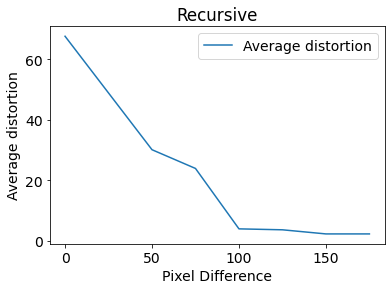

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 14})
x1,y1 = get_distortion('/content/drive/MyDrive/Thesis/1000_advs',X_test)
plt.figure()
plt.plot(x1,y1)
plt.title("Recursive")
plt.legend(["Average distortion"])
plt.xlabel("Pixel Difference")
plt.ylabel("Average distortion")
plt.savefig('plot1.pdf')
plt.show()

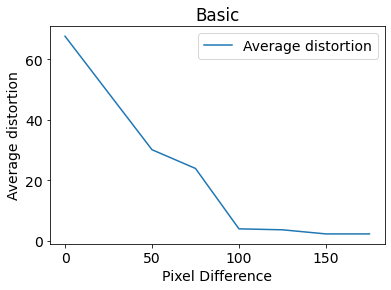

In [ ]:
x1,y1 = get_distortion('/content/drive/MyDrive/Thesis/1000_advs_basic',X_test)
plt.figure()
plt.plot(x1,y1)
plt.title("Basic")
plt.legend(["Average distortion"])
plt.xlabel("Pixel Difference")
plt.ylabel("Average distortion")
plt.savefig('plot1.pdf')
plt.show()

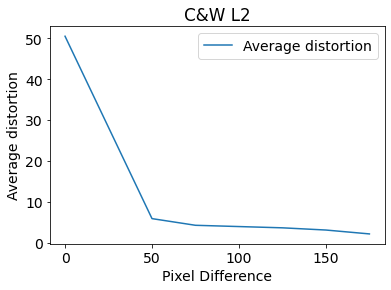

In [ ]:
x1,y1 = get_distortion('/content/drive/MyDrive/Thesis/1000_advs_cw',X_test)
plt.figure()
plt.plot(x1,y1)
plt.title("C&W L2")
plt.legend(["Average distortion"])
plt.xlabel("Pixel Difference")
plt.ylabel("Average distortion")
plt.savefig('plot1.pdf')
plt.show()

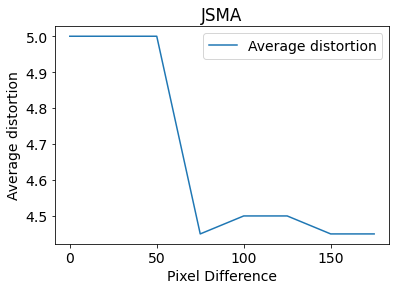

In [ ]:
x1,y1 = get_distortion('/content/drive/MyDrive/Thesis/1000_advs_jsma',X_test)
plt.figure()
plt.plot(x1,y1)
plt.title("JSMA")
plt.legend(["Average distortion"])
plt.xlabel("Pixel Difference")
plt.ylabel("Average distortion")
plt.savefig('plot1.pdf')
plt.show()

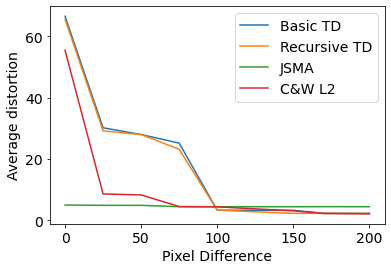

In [ ]:
import matplotlib
matplotlib.rcParams.update({"font.size": 14})
x = [0,25,50,75,100,150,170,200]
basic = [66.6,30.2,28.0,25.2,3.31,3.28,2.28,2.27]
recursive = [65.6,29.2,28.0,23.2,3.31,2.28,2.28,2.27]
jsma = [5,4.9,4.9,4.45,4.45,4.44,4.47,4.45]
cw = [55.5,8.6,8.3,4.5,4.4,3.10,2.25,2.10]
plt.figure()
plt.plot(x,basic)
plt.plot(x,recursive)
plt.plot(x,jsma)
plt.plot(x,cw)
plt.legend(["Basic TD","Recursive TD","JSMA","C&W L2"])
plt.xlabel("Pixel Difference")
plt.ylabel("Average distortion")
plt.savefig('plot1.pdf')
plt.show()

In [ ]:
import time
j=0
for i in tqdm(range(100)):
    j += 1
    time.sleep(1)

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]
